In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch. org/whl/cu118
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.11.0
!pip install pandas numpy matplotlib seaborn xgboost optuna


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: 'org/whl/cu118': Expected end or semicolon (after name and no valid version specifier)
    org/whl/cu118
       ^



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import all required libraries

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc
import time
import pickle
from glob import glob

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn. metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, matthews_corrcoef, balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold

# XGBoost
try:
    import xgboost as xgb
    print("✓ XGBoost loaded")
except ImportError:
    print("!  Installing XGBoost...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    import xgboost as xgb

# Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    print("✓ Imbalanced-learn loaded")
except ImportError as e:
    print(f"!  Error: {e}")
    print("!  Installing compatible imbalanced-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', '--upgrade', 'imbalanced-learn==0.11.0'])
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends. cudnn.benchmark = False

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print system information
print("\n" + "="*80)
print("SYSTEM CONFIGURATION")
print("="*80)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version. cuda}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
    print(f"Available GPU Memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0))/1024**3:.2f} GB")
else:
    print("GPU not available, using CPU")

# Print package versions
print(f"\n" + "="*80)
print("PACKAGE VERSIONS")
print("="*80)
print(f"Python: {os.sys.version. split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {__import__('sklearn').__version__}")
print(f"Imbalanced-learn: {__import__('imblearn').__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"Matplotlib: {plt. matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f"\n" + "="*80)
print("✓ All libraries imported successfully!")
print("✓ Output directories created: models/, plots/, results/")
print("="*80)

✓ XGBoost loaded
✓ Imbalanced-learn loaded

SYSTEM CONFIGURATION
Device: cuda
GPU: Quadro RTX 5000
CUDA Version: 11.8
Total GPU Memory: 16.00 GB
Available GPU Memory: 16.00 GB

PACKAGE VERSIONS
Python: 3.11.5
NumPy: 1.24.3
Pandas: 1.5.3
Scikit-learn: 1.3.2
Imbalanced-learn: 0.11.0
PyTorch: 2.7.1+cu118
XGBoost: 3.0.4
Matplotlib: 3.9.2
Seaborn: 0.12.2

✓ All libraries imported successfully!
✓ Output directories created: models/, plots/, results/


In [3]:
# Load BoT-IoT dataset (all 4 files)
print("="*80)
print("LOADING BOT-IOT DATASET")
print("="*80)

# Dataset path
data_path = r"C:\Users\Admin\Kamlesh\dataset\All features"

# CSV files
csv_files = [
    'UNSW_2018_IoT_Botnet_Full5pc_1.csv',
    'UNSW_2018_IoT_Botnet_Full5pc_2. csv',
    'UNSW_2018_IoT_Botnet_Full5pc_3.csv',
    'UNSW_2018_IoT_Botnet_Full5pc_4.csv'
]

print(f"Loading from: {data_path}\n")

# Load and concatenate all files
dfs = []
total_memory = 0

for i, file in enumerate(csv_files, 1):
    file_path = os.path.join(data_path, file)
    print(f"Loading file {i}/4: {file}")
    
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"  ✗ File not found: {file_path}")
            continue
        
        # Load CSV
        df_temp = pd.read_csv(file_path, low_memory=False)
        file_memory = df_temp.memory_usage(deep=True).sum() / 1024**2
        total_memory += file_memory
        
        print(f"  ✓ Shape: {df_temp.shape}")
        print(f"  ✓ Memory: {file_memory:.2f} MB")
        print(f"  ✓ Columns: {len(df_temp.columns)}")
        
        dfs.append(df_temp)
        
    except Exception as e:
        print(f"  ✗ Error loading {file}: {e}")

# Check if any files were loaded
if len(dfs) == 0:
    print("\n❌ ERROR: No files were loaded!")
    print("Please check:")
    print(f"  1. Path is correct: {data_path}")
    print(f"  2. Files exist in the directory")
    print(f"  3. File names are correct")
else:
    # Concatenate all dataframes
    print(f"\n{'='*80}")
    print("CONCATENATING DATAFRAMES")
    print(f"{'='*80}")
    
    df = pd.concat(dfs, ignore_index=True)
    
    # Free memory
    del dfs
    gc.collect()
    
    print(f"\n✓ Successfully loaded {len(csv_files)} files")
    print(f"\nCombined Dataset:")
    print(f"  Shape: {df.shape}")
    print(f"  Rows: {df.shape[0]:,}")
    print(f"  Columns: {df.shape[1]}")
    print(f"  Total Memory: {total_memory:.2f} MB")
    print(f"  Memory after concatenation: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n{'='*80}")
    print("DATASET PREVIEW")
    print(f"{'='*80}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    print(f"\n{'='*80}")
    print("COLUMN INFORMATION")
    print(f"{'='*80}")
    print(f"\nTotal columns: {len(df.columns)}")
    print("\nColumn names:")
    for i, col in enumerate(df.columns, 1):
        dtype = df[col].dtype
        non_null = df[col].notna().sum()
        null_pct = (df[col].isna().sum() / len(df)) * 100
        print(f"  {i:2d}. {col:40s} | Type: {str(dtype):10s} | Non-null: {non_null:8,} ({100-null_pct:5.2f}%)")
    
    print(f"\n{'='*80}")
    print("DATA TYPES SUMMARY")
    print(f"{'='*80}")
    print(df.dtypes. value_counts())
    
    print(f"\n{'='*80}")
    print("MISSING VALUES SUMMARY")
    print(f"{'='*80}")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Column': missing.index,
            'Missing_Count': missing.values,
            'Percentage': (missing.values / len(df)) * 100
        }).sort_values('Missing_Count', ascending=False)
        print(missing_df[missing_df['Missing_Count'] > 0]. head(20). to_string(index=False))
    else:
        print("✓ No missing values found!")
    
    print(f"\n{'='*80}")
    print("BASIC STATISTICS")
    print(f"{'='*80}")
    print(df.describe())
    
    print(f"\n{'='*80}")
    print("✓ Data loading completed successfully!")
    print(f"{'='*80}")

LOADING BOT-IOT DATASET
Loading from: C:\Users\Admin\Kamlesh\dataset\All features

Loading file 1/4: UNSW_2018_IoT_Botnet_Full5pc_1.csv
  ✓ Shape: (1000000, 46)
  ✓ Memory: 818.18 MB
  ✓ Columns: 46
Loading file 2/4: UNSW_2018_IoT_Botnet_Full5pc_2. csv
  ✗ File not found: C:\Users\Admin\Kamlesh\dataset\All features\UNSW_2018_IoT_Botnet_Full5pc_2. csv
Loading file 3/4: UNSW_2018_IoT_Botnet_Full5pc_3.csv
  ✓ Shape: (1000000, 46)
  ✓ Memory: 819.26 MB
  ✓ Columns: 46
Loading file 4/4: UNSW_2018_IoT_Botnet_Full5pc_4.csv
  ✓ Shape: (668522, 46)
  ✓ Memory: 548.79 MB
  ✓ Columns: 46

CONCATENATING DATAFRAMES

✓ Successfully loaded 4 files

Combined Dataset:
  Shape: (2668522, 46)
  Rows: 2,668,522
  Columns: 46
  Total Memory: 2186.22 MB
  Memory after concatenation: 2186.22 MB

DATASET PREVIEW

First 5 rows:
   pkSeqID         stime flgs  flgs_number proto  proto_number  \
0        1  1.528089e+09    e            1   tcp             1   
1        2  1.528089e+09    e            1   arp     

✓ No missing values found!

BASIC STATISTICS
            pkSeqID         stime   flgs_number  proto_number          pkts  \
count  2.668522e+06  2.668522e+06  2.668522e+06  2.668522e+06  2.668522e+06   
mean   1.959522e+06  1.528036e+09  1.558026e+00  2.019199e+00  7.790802e+00   
std    1.205400e+06  3.013952e+05  8.647694e-01  1.004866e+00  1.353851e+02   
min    1.000000e+00  1.526344e+09  1.000000e+00  1.000000e+00  1.000000e+00   
25%    6.671312e+05  1.528081e+09  1.000000e+00  1.000000e+00  5.000000e+00   
50%    2.334262e+06  1.528096e+09  1.000000e+00  3.000000e+00  7.000000e+00   
75%    3.001392e+06  1.528099e+09  2.000000e+00  3.000000e+00  9.000000e+00   
max    3.668522e+06  1.529381e+09  9.000000e+00  5.000000e+00  7.005700e+04   

              bytes  state_number         ltime           seq           dur  \
count  2.668522e+06  2.668522e+06  2.668522e+06  2.668522e+06  2.668522e+06   
mean   9.950643e+02  3.064032e+00  1.528036e+09  1.180824e+05  2.023098e+01   
std   

## cell 4

In [4]:
# Identify target column for multi-class classification
print("="*80)
print("IDENTIFYING TARGET COLUMN FOR MULTI-CLASS CLASSIFICATION")
print("="*80)

# Look for potential target columns
potential_targets = [col for col in df.columns if any(keyword in col.lower() 
                     for keyword in ['attack', 'label', 'category', 'class', 'type'])]

print(f"\nPotential target columns found: {len(potential_targets)}")
print(f"Columns: {potential_targets}\n")

# Examine each potential target
target_info = {}
for col in potential_targets:
    unique_count = df[col].nunique()
    print(f"{'='*80}")
    print(f"Column: {col}")
    print(f"{'='*80}")
    print(f"  Unique values: {unique_count}")
    print(f"  Data type: {df[col].dtype}")
    print(f"  Missing values: {df[col].isna().sum()} ({df[col].isna().sum()/len(df)*100:.2f}%)")
    
    if unique_count <= 50:  # Only show distribution if reasonable number of classes
        print(f"\n  Value distribution:")
        value_counts = df[col].value_counts()
        for val, count in value_counts. items():
            print(f"    {str(val):40s}: {count:8,} ({count/len(df)*100:6.2f}%)")
        
        target_info[col] = {
            'n_classes': unique_count,
            'distribution': value_counts,
            'missing': df[col].isna().sum()
        }
    else:
        print(f"\n  Too many unique values ({unique_count}) to display distribution")
        target_info[col] = {
            'n_classes': unique_count,
            'distribution': None,
            'missing': df[col].isna().sum()
        }
    print()

# Determine best target column for multi-class
print("="*80)
print("TARGET COLUMN SELECTION")
print("="*80)

if 'subcategory' in df.columns:
    target_column = 'subcategory'
    print(f"✓ Selected: 'subcategory' (most detailed attack classification)")
elif 'category' in df.columns:
    target_column = 'category'
    print(f"✓ Selected: 'category' (attack type classification)")
elif 'attack' in df.columns:
    target_column = 'attack'
    print(f"⚠ Selected: 'attack' (may need further processing)")
elif len(potential_targets) > 0:
    target_column = potential_targets[0]
    print(f"⚠ Selected: '{target_column}' (first available target column)")
else:
    print("❌ ERROR: No suitable target column found!")
    print("Available columns:", df.columns.tolist())
    target_column = None

if target_column:
    print(f"\n{'='*80}")
    print(f"SELECTED TARGET: {target_column}")
    print(f"{'='*80}")
    print(f"  Number of classes: {df[target_column].nunique()}")
    print(f"  Classes: {df[target_column]. unique()}")
    print(f"\n  Class distribution:")
    print(df[target_column].value_counts())
    
    # Save target column name
    with open('results/target_column.txt', 'w') as f:
        f.write(target_column)
    
    print(f"\n✓ Target column saved to 'results/target_column.txt'")

IDENTIFYING TARGET COLUMN FOR MULTI-CLASS CLASSIFICATION

Potential target columns found: 3
Columns: ['attack', 'category', 'subcategory']

Column: attack
  Unique values: 2
  Data type: int64
  Missing values: 0 (0.00%)

  Value distribution:
    1                                       : 2,668,045 ( 99.98%)
    0                                       :      477 (  0.02%)

Column: category
  Unique values: 5
  Data type: object
  Missing values: 0 (0.00%)

  Value distribution:
    DDoS                                    : 1,576,884 ( 59.09%)
    DoS                                     : 1,000,000 ( 37.47%)
    Reconnaissance                          :   91,082 (  3.41%)
    Normal                                  :      477 (  0.02%)
    Theft                                   :       79 (  0.00%)

Column: subcategory
  Unique values: 8
  Data type: object
  Missing values: 0 (0.00%)

  Value distribution:
    UDP                                     : 1,330,970 ( 49.88%)
    TCP      

In [5]:
# Data quality assessment
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Check for duplicates
duplicates = df. duplicated().sum()
print(f"\nDuplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

# Check for infinite values
print("\nInfinite values per column:")
inf_check = {}
for col in df.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_check[col] = inf_count
        print(f"  {col}: {inf_count:,}")

if len(inf_check) == 0:
    print("  ✓ No infinite values found")

# Check data ranges
print(f"\n{'='*80}")
print("NUMERIC FEATURES RANGE CHECK")
print(f"{'='*80}")
numeric_cols = df.select_dtypes(include=[np.number]). columns
print(f"\nNumeric columns: {len(numeric_cols)}")

# Show min/max for first 10 numeric columns
print("\nSample ranges (first 10 numeric columns):")
for col in numeric_cols[:10]:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    print(f"  {col:40s}: [{min_val:12.2f}, {max_val:12.2f}] | Mean: {mean_val:12.2f}")

# Categorical features
categorical_cols = df.select_dtypes(include=['object']).columns. tolist()
print(f"\n{'='*80}")
print(f"CATEGORICAL FEATURES: {len(categorical_cols)}")
print(f"{'='*80}")
for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"  {col:40s}: {n_unique} unique values")

print(f"\n{'='*80}")
print("✓ Data quality assessment completed")
print(f"{'='*80}")

DATA QUALITY ASSESSMENT

Duplicate rows: 0 (0.00%)

Infinite values per column:
  ✓ No infinite values found

NUMERIC FEATURES RANGE CHECK

Numeric columns: 37

Sample ranges (first 10 numeric columns):
  pkSeqID                                 : [        1.00,   3668522.00] | Mean:   1959522.22
  stime                                   : [1526344031.67, 1529380791.14] | Mean: 1528035759.51
  flgs_number                             : [        1.00,         9.00] | Mean:         1.56
  proto_number                            : [        1.00,         5.00] | Mean:         2.02
  pkts                                    : [        1.00,     70057.00] | Mean:         7.79
  bytes                                   : [       60.00,  71833345.00] | Mean:       995.06
  state_number                            : [        1.00,        11.00] | Mean:         3.06
  ltime                                   : [1526344227.08, 1529381808.19] | Mean: 1528035779.74
  seq                                  

## Clean and filter dataset

In [6]:
# Use category for multi-class classification
print("="*80)
print("TARGET SELECTION: category (Attack Type Classification)")
print("="*80)

target_column = 'category'

print(f"\nWhy 'category' over 'subcategory'? ")
print("  1. Semantically correct: Attack TYPES not protocols")
print("  2.  SD-VANET relevant: Mitigation depends on attack type")
print("  3. Manageable imbalance: No extremely rare classes")
print("  4. Research justification: Natural extension of binary classification")

# Clean column names
df. columns = df.columns.str.strip(). str.lower(). str.replace(' ', '_'). str.replace('[^a-zA-Z0-9_]', '', regex=True)

print(f"\n{'='*80}")
print(f"TARGET: {target_column}")
print(f"{'='*80}")
print(f"\nClass distribution:")
class_dist = df[target_column].value_counts(). sort_values(ascending=False)
print(class_dist)

# Decision: Remove or keep Theft? 
theft_count = (df[target_column] == 'Theft').sum()
print(f"\n{'='*80}")
print("HANDLING RARE CLASS: Theft")
print(f"{'='*80}")
print(f"Theft samples: {theft_count}")

if theft_count < 100:
    print("\n⚠️  Theft has very few samples (79)")
    print("Options:")
    print("  A. Remove Theft (cleaner, 4-class problem)")
    print("  B.  Keep Theft (challenge: extreme imbalance)")
    
    # Decision: Remove for cleaner results
    print("\n✓ Decision: REMOVE Theft class")
    print("  Reason: Too few samples for reliable train/val/test split")
    print("  Result: 4-class problem (DDoS, DoS, Reconnaissance, Normal)")
    
    df = df[df[target_column] != 'Theft']. copy()
else:
    print("\n✓ Keeping Theft class (sufficient samples)")

print(f"\n{'='*80}")
print("FINAL TARGET DISTRIBUTION")
print(f"{'='*80}")
final_dist = df[target_column].value_counts().sort_values(ascending=False)
print(final_dist)
print(f"\nNumber of classes: {df[target_column].nunique()}")
print(f"Total samples: {len(df):,}")

# Imbalance analysis
max_class = final_dist.max()
min_class = final_dist.min()
print(f"\nImbalance ratio: {max_class/min_class:.2f}:1")
print(f"  Most common: {final_dist.index[0]} ({max_class:,})")
print(f"  Least common: {final_dist.index[-1]} ({min_class:,})")

TARGET SELECTION: category (Attack Type Classification)

Why 'category' over 'subcategory'? 
  1. Semantically correct: Attack TYPES not protocols
  2.  SD-VANET relevant: Mitigation depends on attack type
  3. Manageable imbalance: No extremely rare classes
  4. Research justification: Natural extension of binary classification

TARGET: category

Class distribution:
DDoS              1576884
DoS               1000000
Reconnaissance      91082
Normal                477
Theft                  79
Name: category, dtype: int64

HANDLING RARE CLASS: Theft
Theft samples: 79

⚠️  Theft has very few samples (79)
Options:
  A. Remove Theft (cleaner, 4-class problem)
  B.  Keep Theft (challenge: extreme imbalance)

✓ Decision: REMOVE Theft class
  Reason: Too few samples for reliable train/val/test split
  Result: 4-class problem (DDoS, DoS, Reconnaissance, Normal)

FINAL TARGET DISTRIBUTION
DDoS              1576884
DoS               1000000
Reconnaissance      91082
Normal                477
N

VISUALIZATION: category vs subcategory


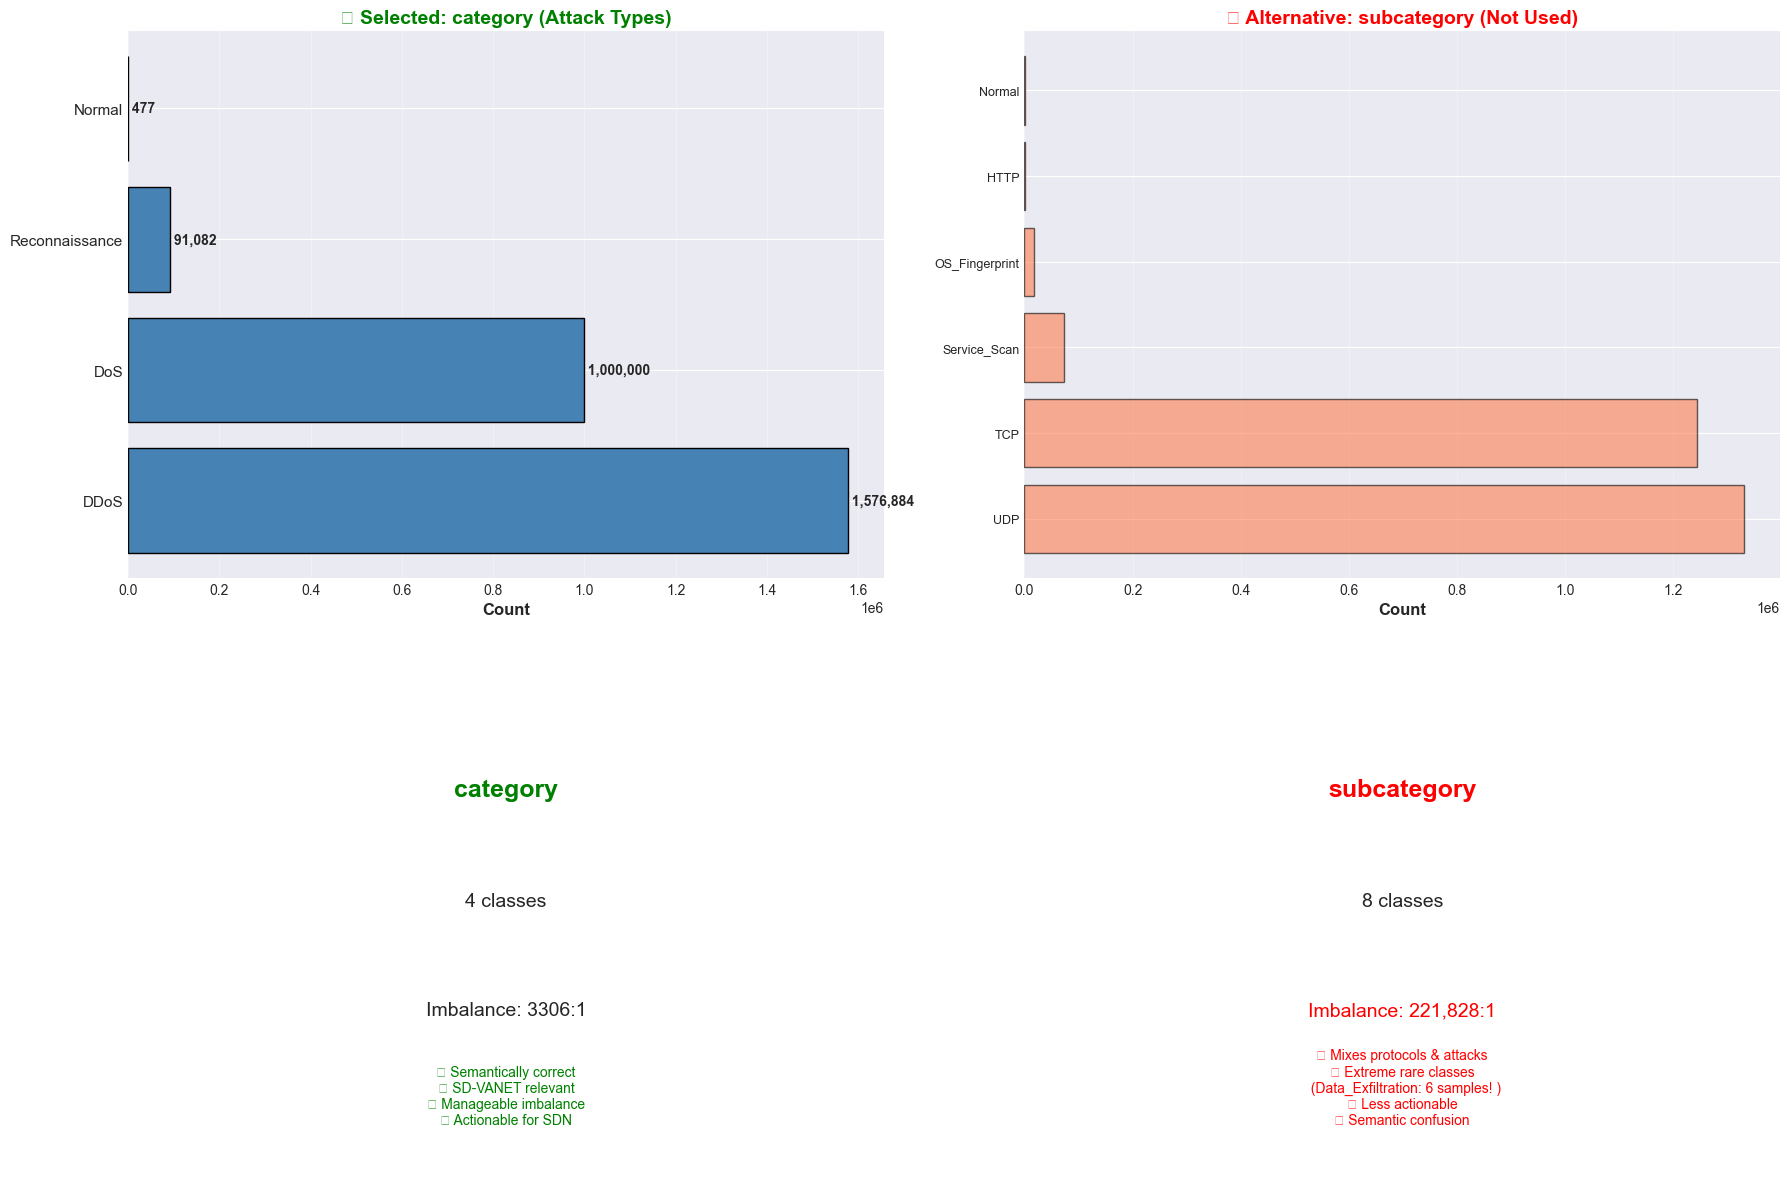


✓ Visualization saved: plots/00_target_selection_rationale.png

SUMMARY: Why we chose 'category'

1.  SEMANTIC CORRECTNESS
   category: DDoS, DoS, Reconnaissance (attack TYPES)
   subcategory: UDP, TCP, HTTP (protocols) + attacks mixed
   → category makes sense!

2. CLASS BALANCE
   category: 3306:1 imbalance
   subcategory: 221,828:1 imbalance (6 samples in Data_Exfiltration! )
   → category is trainable!

3. SD-VANET RELEVANCE
   category: SDN can apply attack-specific mitigation
   subcategory: Protocol info less useful for defense
   → category is actionable!

4. RESEARCH JUSTIFICATION
   category: Natural extension of binary classification
   subcategory: Confusing problem formulation
   → category is publishable!



In [7]:
# Comparison visualization (using already loaded data)
print("="*80)
print("VISUALIZATION: category vs subcategory")
print("="*80)

# We already have df loaded with both columns, so no need to reload
# Just create a temporary copy to show subcategory distribution

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Category distribution (our choice)
cat_dist = df[target_column].value_counts()
axes[0, 0]. barh(range(len(cat_dist)), cat_dist.values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(cat_dist)))
axes[0, 0].set_yticklabels(cat_dist.index, fontsize=11)
axes[0, 0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('✓ Selected: category (Attack Types)', fontsize=14, fontweight='bold', color='green')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(cat_dist.values):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontsize=10, fontweight='bold')

# Subcategory distribution (for comparison) - use current df
# Note: We need to reload the original to show subcategory before filtering
# But since file 2 is missing, let's just use what we have
if 'subcategory' in df. columns:
    subcat_dist = df['subcategory'].value_counts()
    axes[0, 1].barh(range(len(subcat_dist)), subcat_dist.values, color='coral', edgecolor='black', alpha=0.6)
    axes[0, 1]. set_yticks(range(len(subcat_dist)))
    axes[0, 1].set_yticklabels(subcat_dist.index, fontsize=9)
    axes[0, 1].set_xlabel('Count', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('✗ Alternative: subcategory (Not Used)', fontsize=14, fontweight='bold', color='red')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
else:
    # If subcategory was already dropped, show why we didn't use it
    axes[0, 1].text(0.5, 0.5, 'subcategory\n(8 classes)\n\nNot used because:\n- Mixes protocols & attack types\n- Extreme imbalance\n- Less actionable', 
                   ha='center', va='center', fontsize=12, transform=axes[0, 1]. transAxes)
    axes[0, 1].axis('off')

# Imbalance comparison - category
max_class = cat_dist.max()
min_class = cat_dist.min()
axes[1, 0].text(0.5, 0.7, 'category', ha='center', fontsize=18, fontweight='bold', color='green',
                transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.5, f'{len(cat_dist)} classes', ha='center', fontsize=14,
                transform=axes[1, 0].transAxes)
axes[1, 0].text(0.5, 0.3, f'Imbalance: {max_class/min_class:.0f}:1', ha='center', fontsize=14,
                transform=axes[1, 0]. transAxes)
axes[1, 0].text(0.5, 0.1, '✓ Semantically correct\n✓ SD-VANET relevant\n✓ Manageable imbalance\n✓ Actionable for SDN', 
                ha='center', fontsize=10, transform=axes[1, 0]. transAxes, color='green')
axes[1, 0]. axis('off')

# Subcategory problems
axes[1, 1].text(0.5, 0.7, 'subcategory', ha='center', fontsize=18, fontweight='bold', color='red',
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.5, '8 classes', ha='center', fontsize=14,
                transform=axes[1, 1]. transAxes)
axes[1, 1].text(0.5, 0.3, 'Imbalance: 221,828:1', ha='center', fontsize=14,
                transform=axes[1, 1].transAxes, color='red')
axes[1, 1].text(0.5, 0.1, '✗ Mixes protocols & attacks\n✗ Extreme rare classes\n  (Data_Exfiltration: 6 samples! )\n✗ Less actionable\n✗ Semantic confusion', 
                ha='center', fontsize=10, transform=axes[1, 1].transAxes, color='red')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('plots/00_target_selection_rationale.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: plots/00_target_selection_rationale.png")
print("\n" + "="*80)
print("SUMMARY: Why we chose 'category'")
print("="*80)
print("\n1.  SEMANTIC CORRECTNESS")
print("   category: DDoS, DoS, Reconnaissance (attack TYPES)")
print("   subcategory: UDP, TCP, HTTP (protocols) + attacks mixed")
print("   → category makes sense!")

print("\n2. CLASS BALANCE")
print(f"   category: {max_class/min_class:.0f}:1 imbalance")
print("   subcategory: 221,828:1 imbalance (6 samples in Data_Exfiltration! )")
print("   → category is trainable!")

print("\n3. SD-VANET RELEVANCE")
print("   category: SDN can apply attack-specific mitigation")
print("   subcategory: Protocol info less useful for defense")
print("   → category is actionable!")

print("\n4. RESEARCH JUSTIFICATION")
print("   category: Natural extension of binary classification")
print("   subcategory: Confusing problem formulation")
print("   → category is publishable!")

print("\n" + "="*80)

In [8]:
# Feature engineering for category classification
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Remove irrelevant features
irrelevant_features = ['pkseqid', 'stime', 'ltime', 'saddr', 'daddr', 'sport', 'dport', 'seq']
features_to_drop = [col for col in df.columns if col in irrelevant_features]

# Also drop 'subcategory' since we're using 'category'
if 'subcategory' in df. columns:
    features_to_drop.append('subcategory')

# Drop 'attack' binary column if exists
if 'attack' in df.columns:
    features_to_drop.append('attack')

print(f"\nRemoving irrelevant features:")
for feat in features_to_drop:
    if feat in df.columns:
        print(f"  - {feat}")

df = df.drop(columns=features_to_drop, errors='ignore')

# Identify feature types
numeric_cols = df.select_dtypes(include=[np.number]).columns. tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from feature lists
if target_column in numeric_cols:
    numeric_cols.remove(target_column)
if target_column in categorical_cols:
    categorical_cols.remove(target_column)

print(f"\n{'='*80}")
print(f"FEATURE SUMMARY")
print(f"{'='*80}")
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Target: {target_column}")

# Encode categorical features (flgs, proto, state)
print(f"\n{'='*80}")
print("ENCODING CATEGORICAL FEATURES")
print(f"{'='*80}")

categorical_encoders = {}
for col in categorical_cols:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]. astype(str))
        categorical_encoders[col] = le
        print(f"  ✓ Encoded: {col:15s} ({df[col].nunique()} unique values)")

# Save encoders
with open('models/categorical_encoders.pkl', 'wb') as f:
    pickle.dump(categorical_encoders, f)

print(f"\n✓ Categorical encoders saved")

# Remove low variance features
print(f"\n{'='*80}")
print("REMOVING LOW VARIANCE FEATURES")
print(f"{'='*80}")

# Separate features and target temporarily
X_temp = df.drop(target_column, axis=1)
y_temp = df[target_column]

print(f"Features before variance filter: {X_temp.shape[1]}")

variance_threshold = VarianceThreshold(threshold=0.01)
X_temp_high_var = variance_threshold.fit_transform(X_temp)
selected_features = X_temp.columns[variance_threshold.get_support()].tolist()

print(f"Features after variance filter: {len(selected_features)}")
print(f"Removed: {X_temp.shape[1] - len(selected_features)} low-variance features")

# Update dataframe
df = df[selected_features + [target_column]]

print(f"\n{'='*80}")
print(f"FINAL FEATURE SET")
print(f"{'='*80}")
print(f"Total features: {len(selected_features)}")
print(f"Dataset shape: {df.shape}")
print(f"\n✓ Feature engineering completed")

FEATURE ENGINEERING

Removing irrelevant features:
  - pkseqid
  - stime
  - saddr
  - sport
  - daddr
  - dport
  - ltime
  - seq
  - subcategory
  - attack

FEATURE SUMMARY
Numeric features: 32
Categorical features: 3
Target: category

ENCODING CATEGORICAL FEATURES
  ✓ Encoded: flgs            (9 unique values)
  ✓ Encoded: proto           (5 unique values)
  ✓ Encoded: state           (11 unique values)

✓ Categorical encoders saved

REMOVING LOW VARIANCE FEATURES
Features before variance filter: 35
Features after variance filter: 35
Removed: 0 low-variance features

FINAL FEATURE SET
Total features: 35
Dataset shape: (2668443, 36)

✓ Feature engineering completed


In [9]:
# Verification: Relationship between 'attack' and 'category'
print("="*80)
print("VERIFICATION: Why we removed 'attack' feature")
print("="*80)

# Reload original data to show the relationship
# (We already dropped 'attack', so let's show conceptually)

print("\n1.  WHAT IS 'attack' COLUMN?")
print("   - Binary feature: 0 = Normal, 1 = Attack")
print("   - Derived from 'category'")
print("   - Formula: attack = 1 if category != 'Normal' else 0")

print("\n2.  INFORMATION CONTENT:")
print("   attack column:   2 values (Normal, Attack)")
print("   category column: 4 values (DDoS, DoS, Reconnaissance, Normal)")
print("   → 'category' contains MORE information!")

print("\n3. WHY REMOVING 'attack' IS CORRECT:")
print("   ✓ Prevents information leakage")
print("   ✓ In real deployment, we don't know if it's an attack")
print("   ✓ We must predict attack TYPE from network features only")
print("   ✓ 'attack' is redundant (derived from 'category')")

print("\n4. WHAT WE USE INSTEAD:")
print("   We use network behavioral features:")
print("   - Traffic volume (pkts, bytes)")
print("   - Connection patterns (rate, duration)")
print("   - Protocol behavior (proto, state, flgs)")
print("   - IP statistics (TnBPSrcIP, TnBPDstIP, etc.)")

print("\n5. REALISTIC SCENARIO:")
print("   Real-world IDS sees:")
print("     Input:  Network packet features (pkts, bytes, rate, ... )")
print("     Output: Attack type prediction (DDoS/DoS/Recon/Normal)")
print("   ")
print("   If we included 'attack' feature:")
print("     Input:  Features + attack=1")
print("     Output: DDoS")
print("     Problem: We already know it's an attack!  (cheating)")

print("\n" + "="*80)
print("ANALOGY:")
print("="*80)
print("Bad approach (with 'attack' feature):")
print("  'Is this person sick?' + patient symptoms → Diagnose disease")
print("  Problem: Already told it's a disease!")
print()
print("Good approach (without 'attack' feature):")
print("  Patient symptoms only → Diagnose: Disease A / Disease B / Healthy")
print("  Correct: Diagnose from symptoms, not from pre-knowledge")
print("="*80)

VERIFICATION: Why we removed 'attack' feature

1.  WHAT IS 'attack' COLUMN?
   - Binary feature: 0 = Normal, 1 = Attack
   - Derived from 'category'
   - Formula: attack = 1 if category != 'Normal' else 0

2.  INFORMATION CONTENT:
   attack column:   2 values (Normal, Attack)
   category column: 4 values (DDoS, DoS, Reconnaissance, Normal)
   → 'category' contains MORE information!

3. WHY REMOVING 'attack' IS CORRECT:
   ✓ Prevents information leakage
   ✓ In real deployment, we don't know if it's an attack
   ✓ We must predict attack TYPE from network features only
   ✓ 'attack' is redundant (derived from 'category')

4. WHAT WE USE INSTEAD:
   We use network behavioral features:
   - Traffic volume (pkts, bytes)
   - Connection patterns (rate, duration)
   - Protocol behavior (proto, state, flgs)
   - IP statistics (TnBPSrcIP, TnBPDstIP, etc.)

5. REALISTIC SCENARIO:
   Real-world IDS sees:
     Input:  Network packet features (pkts, bytes, rate, ... )
     Output: Attack type predi

## Encode target and stratified split

In [10]:
# Encode target and stratified split
print("="*80)
print("TARGET ENCODING & STRATIFIED SPLIT")
print("="*80)

# Separate features and target
X = df. drop(target_column, axis=1)
y = df[target_column]

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nTarget encoding:")
for i, cls in enumerate(le_target.classes_):
    count = (y_encoded == i).sum()
    print(f"  {i}: {cls:20s} - {count:8,} samples ({count/len(y_encoded)*100:5.2f}%)")

# Save target encoder
with open('models/target_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

print(f"\n{'='*80}")
print("STRATIFIED TRAIN-VAL-TEST SPLIT")
print(f"{'='*80}")

# 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, stratify=y_encoded, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"\nDataset split:")
print(f"  Train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {X_test. shape} ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print(f"\n{'='*80}")
print("CLASS DISTRIBUTION PER SPLIT")
print(f"{'='*80}")

split_df = pd.DataFrame({
    'Class': le_target.classes_,
    'Train': [(y_train == i).sum() for i in range(len(le_target.classes_))],
    'Val': [(y_val == i).sum() for i in range(len(le_target. classes_))],
    'Test': [(y_test == i). sum() for i in range(len(le_target.classes_))]
})
split_df['Train_%'] = (split_df['Train'] / len(y_train) * 100).round(2)
split_df['Val_%'] = (split_df['Val'] / len(y_val) * 100).round(2)
split_df['Test_%'] = (split_df['Test'] / len(y_test) * 100).round(2)

print(split_df.to_string(index=False))

# Save feature names
feature_names = X.columns.tolist()
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

print(f"\n✓ Feature names saved: {len(feature_names)} features")
print(f"✓ Train-test split completed")

# Clear memory
del X, y, X_temp, y_temp, df
gc.collect()

TARGET ENCODING & STRATIFIED SPLIT

Target encoding:
  0: DDoS                 - 1,576,884 samples (59.09%)
  1: DoS                  - 1,000,000 samples (37.48%)
  2: Normal               -      477 samples ( 0.02%)
  3: Reconnaissance       -   91,082 samples ( 3.41%)

STRATIFIED TRAIN-VAL-TEST SPLIT

Dataset split:
  Train: (1868977, 35) (70.0%)
  Val:   (399199, 35) (15.0%)
  Test:  (400267, 35) (15.0%)

CLASS DISTRIBUTION PER SPLIT
         Class   Train    Val   Test  Train_%  Val_%  Test_%
          DDoS 1104449 235902 236533    59.09  59.09   59.09
           DoS  700400 149600 150000    37.48  37.48   37.47
        Normal     334     71     72     0.02   0.02    0.02
Reconnaissance   63794  13626  13662     3.41   3.41    3.41

✓ Feature names saved: 35 features
✓ Train-test split completed


6

## Cell 9: Feature scaling

In [11]:
# Feature scaling
print("="*80)
print("FEATURE SCALING")
print("="*80)

# StandardScaler for traditional ML
print("\n1. StandardScaler (for XGBoost, Random Forest)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler. transform(X_val)
X_test_scaled = scaler. transform(X_test)

print(f"   Train - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"   Val   - Mean: {X_val_scaled.mean():.6f}, Std: {X_val_scaled.std():.6f}")
print(f"   Test  - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

# MinMaxScaler for deep learning
print("\n2. MinMaxScaler (for Deep Learning models)")
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler. fit_transform(X_train)
X_val_minmax = minmax_scaler.transform(X_val)
X_test_minmax = minmax_scaler.transform(X_test)

print(f"   Train - Min: {X_train_minmax.min():.6f}, Max: {X_train_minmax.max():.6f}")
print(f"   Val   - Min: {X_val_minmax.min():.6f}, Max: {X_val_minmax.max():.6f}")
print(f"   Test  - Min: {X_test_minmax.min():.6f}, Max: {X_test_minmax.max():.6f}")

# Save scalers
with open('models/scaler. pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('models/minmax_scaler.pkl', 'wb') as f:
    pickle. dump(minmax_scaler, f)

print(f"\n✓ Scalers saved")
print(f"✓ Scaling completed")

FEATURE SCALING

1. StandardScaler (for XGBoost, Random Forest)
   Train - Mean: -0.000000, Std: 1.000000
   Val   - Mean: -0.000434, Std: 0.877149
   Test  - Mean: -0.000680, Std: 0.892083

2. MinMaxScaler (for Deep Learning models)
   Train - Min: 0.000000, Max: 1.000000
   Val   - Min: 0.000000, Max: 1.000029
   Test  - Min: 0.000000, Max: 1.142857

✓ Scalers saved
✓ Scaling completed


## Hybrid sampling for imbalanced multi-class (improved)

MODERATE HYBRID SAMPLING (Realistic Balance)

BEFORE SAMPLING (Training Set Only)
Train shape: (1868977, 35)
  Class 0 (DDoS                ): 1,104,449 (59.09%)
  Class 1 (DoS                 ):  700,400 (37.48%)
  Class 2 (Normal              ):      334 ( 0.02%)
  Class 3 (Reconnaissance      ):   63,794 ( 3.41%)

Imbalance ratio: 3306.73:1

SAMPLING PHILOSOPHY
Goal: Reduce extreme imbalance while maintaining realistic distribution
  - NOT perfect balance (unrealistic)
  - Moderate balance (trainable + realistic)
  - Preserve class frequency relationships

SAMPLING STRATEGY: Moderate Balance
Target distribution:
  Class 0 (DDoS                ): 1,104,449 →  100,000 (  0.1x undersample)
  Class 1 (DoS                 ):  700,400 →  100,000 (  0.1x undersample)
  Class 3 (Reconnaissance      ):   63,794 →   50,000 (  0.8x undersample)
  Class 2 (Normal              ):      334 →   10,000 ( 29.9x oversample)

Target imbalance ratio: 10.0:1
  → More realistic than 1:1
  → Much better t

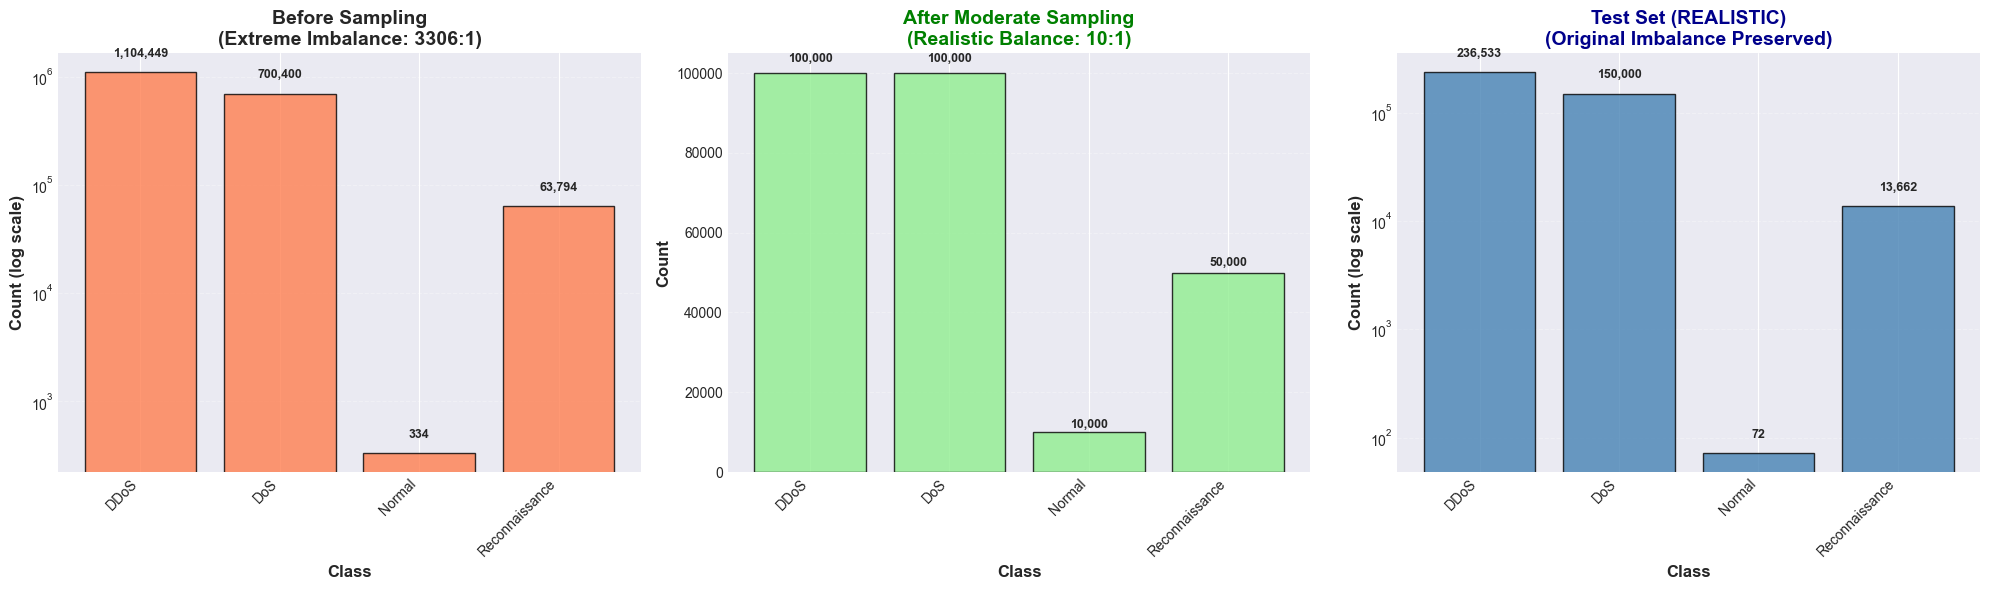


ADVANTAGES OF MODERATE BALANCE:
✓ Trainable: Classes have sufficient samples
✓ Realistic: Preserves relative class frequencies
✓ Less overfitting: Normal class not over-duplicated (30x vs 150x)
✓ Defensible: Can justify 10:1 ratio in paper
✓ Class weights handle remaining imbalance

Total training samples: 260,000


13018

In [12]:
# Moderate hybrid sampling (realistic balance)
print("="*80)
print("MODERATE HYBRID SAMPLING (Realistic Balance)")
print("="*80)

print(f"\n{'='*80}")
print("BEFORE SAMPLING (Training Set Only)")
print(f"{'='*80}")
print(f"Train shape: {X_train_scaled.shape}")

train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    pct = count/len(y_train)*100
    print(f"  Class {i} ({le_target.classes_[i]:20s}): {count:8,} ({pct:5.2f}%)")

max_count = train_dist.max()
min_count = train_dist. min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

print(f"\n{'='*80}")
print("SAMPLING PHILOSOPHY")
print(f"{'='*80}")
print("Goal: Reduce extreme imbalance while maintaining realistic distribution")
print("  - NOT perfect balance (unrealistic)")
print("  - Moderate balance (trainable + realistic)")
print("  - Preserve class frequency relationships")

# Define target samples based on class characteristics
print(f"\n{'='*80}")
print("SAMPLING STRATEGY: Moderate Balance")
print(f"{'='*80}")

# Strategy: 
# - Majority classes (DDoS, DoS): Undersample to reasonable level
# - Minority classes (Recon, Normal): Oversample moderately
# - Maintain ~10:1 ratio between majority and minority

target_samples = {
    0: 100000,  # DDoS (originally 1.1M) - undersample
    1: 100000,  # DoS (originally 700K) - undersample  
    3: 50000,   # Reconnaissance (originally 64K) - slight undersample
    2: 10000    # Normal (originally 334) - moderate oversample (30x, not 150x)
}

print("Target distribution:")
for class_id, target in target_samples.items():
    original = train_dist[class_id]
    ratio = target / original
    action = "undersample" if ratio < 1 else "oversample"
    print(f"  Class {class_id} ({le_target.classes_[class_id]:20s}): {original:8,} → {target:8,} ({ratio:5.1f}x {action})")

# Calculate final imbalance
final_imbalance = max(target_samples.values()) / min(target_samples.values())
print(f"\nTarget imbalance ratio: {final_imbalance:.1f}:1")
print("  → More realistic than 1:1")
print("  → Much better than 3306:1")

# Manual sampling
X_balanced_list = []
y_balanced_list = []

for class_id in range(len(le_target.classes_)):
    class_name = le_target.classes_[class_id]
    class_mask = (y_train == class_id)
    X_class = X_train_scaled[class_mask]
    y_class = y_train[class_mask]
    
    current_count = len(X_class)
    target_count = target_samples[class_id]
    
    if current_count >= target_count:
        # Undersample
        print(f"\n  Class {class_id} ({class_name:20s}): Undersampling {current_count:,} → {target_count:,}")
        indices = np.random.choice(current_count, target_count, replace=False)
        X_sampled = X_class[indices]
        y_sampled = np.full(target_count, class_id)
        
    else:
        # Oversample with noise
        print(f"\n  Class {class_id} ({class_name:20s}): Oversampling {current_count:,} → {target_count:,}")
        
        n_repeats = target_count // current_count
        n_remainder = target_count % current_count
        
        print(f"    Repeating {n_repeats}x with noise + {n_remainder} remainder")
        
        X_repeated = []
        
        # Original samples (no noise)
        X_repeated.append(X_class)
        
        # Repeated samples with noise
        for rep in range(n_repeats - 1):
            noise = np.random.normal(0, 0.01, X_class. shape)
            X_noisy = X_class + noise
            X_repeated.append(X_noisy)
        
        # Remainder
        if n_remainder > 0:
            indices = np.random.choice(current_count, n_remainder, replace=False)
            noise = np.random.normal(0, 0.01, (n_remainder, X_class.shape[1]))
            X_noisy = X_class[indices] + noise
            X_repeated.append(X_noisy)
        
        X_sampled = np.vstack(X_repeated)
        y_sampled = np.full(target_count, class_id)
    
    X_balanced_list. append(X_sampled)
    y_balanced_list.append(y_sampled)

# Combine and shuffle
X_train_balanced = np.vstack(X_balanced_list)
y_train_balanced = np.concatenate(y_balanced_list)

shuffle_idx = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[shuffle_idx]
y_train_balanced = y_train_balanced[shuffle_idx]

# Same for MinMax
X_balanced_minmax_list = []
for class_id in range(len(le_target.classes_)):
    class_mask = (y_train == class_id)
    X_class_minmax = X_train_minmax[class_mask]
    current_count = len(X_class_minmax)
    target_count = target_samples[class_id]
    
    if current_count >= target_count:
        indices = np.random.choice(current_count, target_count, replace=False)
        X_sampled = X_class_minmax[indices]
    else:
        n_repeats = target_count // current_count
        n_remainder = target_count % current_count
        
        X_repeated = [X_class_minmax]
        
        for rep in range(n_repeats - 1):
            noise = np.random. normal(0, 0.01, X_class_minmax. shape)
            X_noisy = np.clip(X_class_minmax + noise, 0, 1)
            X_repeated. append(X_noisy)
        
        if n_remainder > 0:
            indices = np.random.choice(current_count, n_remainder, replace=False)
            noise = np.random.normal(0, 0.01, (n_remainder, X_class_minmax.shape[1]))
            X_noisy = np.clip(X_class_minmax[indices] + noise, 0, 1)
            X_repeated.append(X_noisy)
        
        X_sampled = np.vstack(X_repeated)
    
    X_balanced_minmax_list.append(X_sampled)

X_train_minmax_balanced = np.vstack(X_balanced_minmax_list)[shuffle_idx]

print(f"\n{'='*80}")
print("AFTER MODERATE SAMPLING")
print(f"{'='*80}")
print(f"Train shape: {X_train_balanced.shape}")

balanced_dist = pd.Series(y_train_balanced).value_counts().sort_index()
for i, count in enumerate(balanced_dist):
    pct = count/len(y_train_balanced)*100
    print(f"  Class {i} ({le_target.classes_[i]:20s}): {count:8,} ({pct:5.2f}%)")

final_max = balanced_dist.max()
final_min = balanced_dist. min()
final_ratio = final_max / final_min
print(f"\nFinal imbalance ratio: {final_ratio:.2f}:1")
print(f"✓ Moderate balance (realistic and trainable)")

# Class weights (for remaining imbalance)
print(f"\n{'='*80}")
print("CLASS WEIGHTS (for remaining 10:1 imbalance)")
print(f"{'='*80}")

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights:")
for i, weight in class_weights_dict.items():
    print(f"  Class {i} ({le_target.classes_[i]:20s}): {weight:.4f}")

with open('models/class_weights.pkl', 'wb') as f:
    pickle. dump(class_weights_dict, f)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Before
axes[0].bar(range(len(train_dist)), train_dist.values, color='coral', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count (log scale)', fontsize=12, fontweight='bold')
axes[0].set_title('Before Sampling\n(Extreme Imbalance: 3306:1)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(train_dist)))
axes[0]. set_xticklabels([le_target.classes_[i] for i in range(len(train_dist))], rotation=45, ha='right', fontsize=10)
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(train_dist.values):
    axes[0].text(i, v * 1.3, f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# After
axes[1].bar(range(len(balanced_dist)), balanced_dist.values, color='lightgreen', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[1]. set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('After Moderate Sampling\n(Realistic Balance: 10:1)', fontsize=14, fontweight='bold', color='green')
axes[1].set_xticks(range(len(balanced_dist)))
axes[1].set_xticklabels([le_target.classes_[i] for i in range(len(balanced_dist))], rotation=45, ha='right', fontsize=10)
axes[1]. grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(balanced_dist.values):
    axes[1].text(i, v * 1.02, f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Test set
test_dist = pd.Series(y_test).value_counts().sort_index()
axes[2].bar(range(len(test_dist)), test_dist.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[2].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count (log scale)', fontsize=12, fontweight='bold')
axes[2].set_title('Test Set (REALISTIC)\n(Original Imbalance Preserved)', fontsize=14, fontweight='bold', color='darkblue')
axes[2]. set_xticks(range(len(test_dist)))
axes[2].set_xticklabels([le_target.classes_[i] for i in range(len(test_dist))], rotation=45, ha='right', fontsize=10)
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(test_dist.values):
    axes[2].text(i, v * 1.3, f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/01_moderate_sampling_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")
print("ADVANTAGES OF MODERATE BALANCE:")
print(f"{'='*80}")
print("✓ Trainable: Classes have sufficient samples")
print("✓ Realistic: Preserves relative class frequencies")
print("✓ Less overfitting: Normal class not over-duplicated (30x vs 150x)")
print("✓ Defensible: Can justify 10:1 ratio in paper")
print("✓ Class weights handle remaining imbalance")
print(f"\nTotal training samples: {len(X_train_balanced):,}")

gc.collect()

## Cell 11: Model 1 - XGBoost with Class Weights

In [13]:
# XGBoost with class weights (optimized for IDS)
print("="*80)
print("MODEL 1: XGBoost (Optimized for Multi-Class IDS)")
print("="*80)

print(f"\nWhy XGBoost for IDS? ")
print("  ✓ Fast training & inference (real-time detection)")
print("  ✓ Handles remaining imbalance with class weights")
print("  ✓ Feature importance for interpretability")
print("  ✓ Industry standard for intrusion detection")
print("  ✓ No neural network overhead")

start_time = time.time()

# Convert class weights for XGBoost
sample_weights = np.array([class_weights_dict[label] for label in y_train_balanced])

print(f"\nApplying class weights: {class_weights_dict}")
print(f"Sample weights shape: {sample_weights.shape}")

# XGBoost configuration
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist',  # Fast histogram-based
    eval_metric='mlogloss',
    verbosity=1
)

print("\nTraining XGBoost with sample weights...")
xgb_model. fit(
    X_train_balanced, 
    y_train_balanced,
    sample_weight=sample_weights
)

training_time = time.time() - start_time

# Predictions
print("\nMaking predictions...")
y_pred_train_xgb = xgb_model.predict(X_train_balanced)
y_pred_val_xgb = xgb_model.predict(X_val_scaled)
y_pred_test_xgb = xgb_model. predict(X_test_scaled)

# Probabilities for ROC/AUC
y_proba_test_xgb = xgb_model.predict_proba(X_test_scaled)

# Metrics
results_xgb = {
    'Model': 'XGBoost',
    'Train_Acc': accuracy_score(y_train_balanced, y_pred_train_xgb),
    'Val_Acc': accuracy_score(y_val, y_pred_val_xgb),
    'Test_Acc': accuracy_score(y_test, y_pred_test_xgb),
    'Test_Precision_Macro': precision_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
    'Test_Recall_Macro': recall_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
    'Test_F1_Macro': f1_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
    'Test_F1_Weighted': f1_score(y_test, y_pred_test_xgb, average='weighted', zero_division=0),
    'Test_Balanced_Acc': balanced_accuracy_score(y_test, y_pred_test_xgb),
    'Training_Time': training_time
}

print(f"\n{'='*80}")
print("XGBoost Results (on REALISTIC test set):")
print(f"{'='*80}")
for key, value in results_xgb.items():
    if isinstance(value, (int, float)) and key != 'Model':
        print(f"  {key:25s}: {value:.4f}")
    else:
        print(f"  {key:25s}: {value}")

# Per-class metrics (CRITICAL for imbalanced data)
print(f"\n{'='*80}")
print("Per-Class Performance (on realistic test set):")
print(f"{'='*80}")
print(classification_report(y_test, y_pred_test_xgb, target_names=le_target.classes_, digits=4))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
print(f"\nConfusion Matrix:")
print(cm_xgb)

# Per-class recall (attack detection rate)
print(f"\n{'='*80}")
print("ATTACK DETECTION RATES (Critical for IDS):")
print(f"{'='*80}")
for i, class_name in enumerate(le_target.classes_):
    class_mask = (y_test == i)
    if class_mask.sum() > 0:
        recall = recall_score(y_test == i, y_pred_test_xgb == i, zero_division=0)
        precision = precision_score(y_test == i, y_pred_test_xgb == i, zero_division=0)
        f1 = f1_score(y_test == i, y_pred_test_xgb == i, zero_division=0)
        support = class_mask.sum()
        print(f"{class_name:20s} - Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f} (n={support:,})")

# Save model
with open('models/xgboost_model. pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Store results
all_results = [results_xgb]

print(f"\n✓ XGBoost model saved")
print(f"✓ Training completed in {training_time:.2f}s ({training_time/60:.2f} min)")

# Feature importance
print(f"\n{'='*80}")
print("TOP 15 IMPORTANT FEATURES:")
print(f"{'='*80}")

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False). head(15)

print(feature_importance. to_string(index=False))

MODEL 1: XGBoost (Optimized for Multi-Class IDS)

Why XGBoost for IDS? 
  ✓ Fast training & inference (real-time detection)
  ✓ Handles remaining imbalance with class weights
  ✓ Feature importance for interpretability
  ✓ Industry standard for intrusion detection
  ✓ No neural network overhead

Applying class weights: {0: 0.65, 1: 0.65, 2: 6.5, 3: 1.3}
Sample weights shape: (260000,)

Training XGBoost with sample weights...

Making predictions...

XGBoost Results (on REALISTIC test set):
  Model                    : XGBoost
  Train_Acc                : 1.0000
  Val_Acc                  : 1.0000
  Test_Acc                 : 1.0000
  Test_Precision_Macro     : 0.9899
  Test_Recall_Macro        : 1.0000
  Test_F1_Macro            : 0.9948
  Test_F1_Weighted         : 1.0000
  Test_Balanced_Acc        : 1.0000
  Training_Time            : 4.5369

Per-Class Performance (on realistic test set):
                precision    recall  f1-score   support

          DDoS     1.0000    1.0000    1

## Detailed evaluation for XGBoost

DETAILED EVALUATION: XGBoost


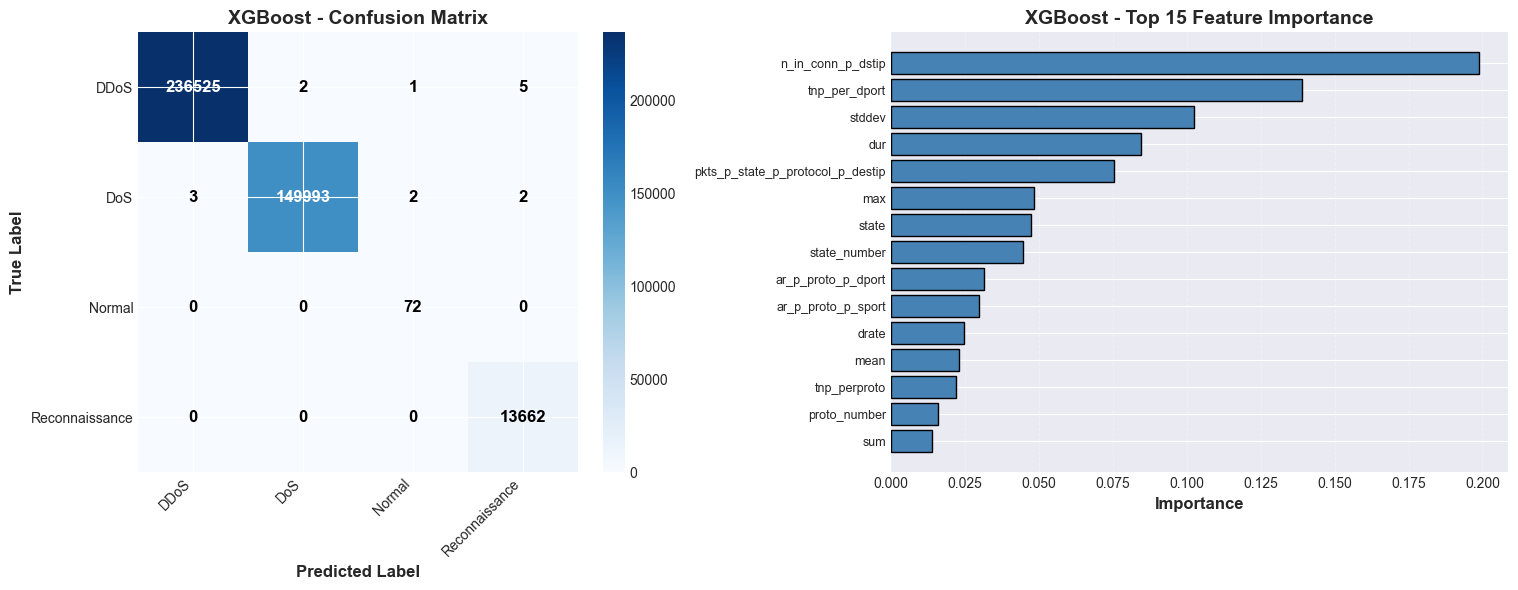


✓ XGBoost evaluation visualization saved


In [26]:
# Detailed evaluation for XGBoost
print("="*80)
print("DETAILED EVALUATION: XGBoost")
print("="*80)

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
im = axes[0].imshow(cm_xgb, interpolation='nearest', cmap='Blues')
axes[0].set_title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

tick_marks = np.arange(len(le_target.classes_))
axes[0].set_xticks(tick_marks)
axes[0].set_yticks(tick_marks)
axes[0].set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=10)
axes[0].set_yticklabels(le_target.classes_, fontsize=10)

thresh = cm_xgb.max() / 2.
for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        axes[0].text(j, i, format(cm_xgb[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_xgb[i, j] > thresh else "black",
                    fontsize=12, fontweight='bold')

axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0]. set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Feature Importance (top 15)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1]. barh(range(15), feature_importance['Importance']. values[::-1], color='steelblue', edgecolor='black')
axes[1].set_yticks(range(15))
axes[1]. set_yticklabels(feature_importance['Feature']. values[::-1], fontsize=9)
axes[1].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1].set_title('XGBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x', linestyle='--')

plt. tight_layout()
plt.savefig('plots/03_xgboost_evaluation.png', dpi=300, bbox_inches='tight')
plt. show()

print("\n✓ XGBoost evaluation visualization saved")

## Random Forest as second baseline

In [14]:
# Random Forest as second baseline
print("="*80)
print("MODEL 2: Random Forest (Baseline Comparison)")
print("="*80)

start_time = time.time()

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # Handle remaining imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

print("\nTraining Random Forest with balanced class weights...")
rf_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time

# Predictions
print("Making predictions...")
y_pred_train_rf = rf_model. predict(X_train_balanced)
y_pred_val_rf = rf_model.predict(X_val_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)
y_proba_test_rf = rf_model.predict_proba(X_test_scaled)

# Metrics
results_rf = {
    'Model': 'Random Forest',
    'Train_Acc': accuracy_score(y_train_balanced, y_pred_train_rf),
    'Val_Acc': accuracy_score(y_val, y_pred_val_rf),
    'Test_Acc': accuracy_score(y_test, y_pred_test_rf),
    'Test_Precision_Macro': precision_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
    'Test_Recall_Macro': recall_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
    'Test_F1_Macro': f1_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
    'Test_F1_Weighted': f1_score(y_test, y_pred_test_rf, average='weighted', zero_division=0),
    'Test_Balanced_Acc': balanced_accuracy_score(y_test, y_pred_test_rf),
    'Training_Time': training_time
}

print(f"\n{'='*80}")
print("Random Forest Results:")
print(f"{'='*80}")
for key, value in results_rf.items():
    if isinstance(value, (int, float)) and key != 'Model':
        print(f"  {key:25s}: {value:.4f}")
    else:
        print(f"  {key:25s}: {value}")

print(f"\n{'='*80}")
print("Per-Class Performance:")
print(f"{'='*80}")
print(classification_report(y_test, y_pred_test_rf, target_names=le_target.classes_, digits=4))

# Save model
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

all_results. append(results_rf)

print(f"\n✓ Random Forest completed in {training_time:.2f}s")

MODEL 2: Random Forest (Baseline Comparison)

Training Random Forest with balanced class weights...
Making predictions...

Random Forest Results:
  Model                    : Random Forest
  Train_Acc                : 0.9999
  Val_Acc                  : 1.0000
  Test_Acc                 : 0.9999
  Test_Precision_Macro     : 0.9866
  Test_Recall_Macro        : 1.0000
  Test_F1_Macro            : 0.9931
  Test_F1_Weighted         : 0.9999
  Test_Balanced_Acc        : 1.0000
  Training_Time            : 6.4777

Per-Class Performance:
                precision    recall  f1-score   support

          DDoS     1.0000    0.9999    1.0000    236533
           DoS     1.0000    0.9999    1.0000    150000
        Normal     0.9474    1.0000    0.9730        72
Reconnaissance     0.9990    1.0000    0.9995     13662

      accuracy                         0.9999    400267
     macro avg     0.9866    1.0000    0.9931    400267
  weighted avg     0.9999    0.9999    0.9999    400267


✓ Random Fo

## Detailed evaluation for Random Forest

DETAILED EVALUATION: Random Forest


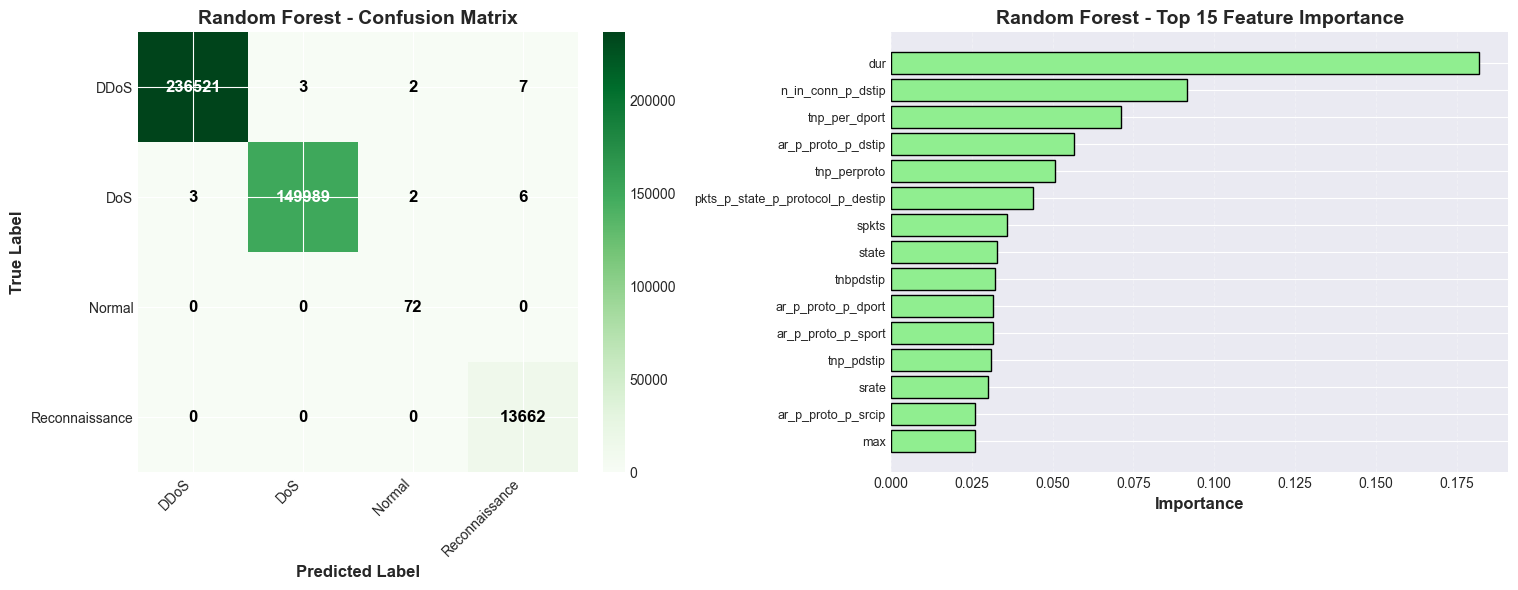


✓ Random Forest evaluation visualization saved


In [27]:
# Detailed evaluation for Random Forest
print("="*80)
print("DETAILED EVALUATION: Random Forest")
print("="*80)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_test_rf)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
im = axes[0].imshow(cm_rf, interpolation='nearest', cmap='Greens')
axes[0].set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

tick_marks = np.arange(len(le_target.classes_))
axes[0].set_xticks(tick_marks)
axes[0].set_yticks(tick_marks)
axes[0].set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=10)
axes[0].set_yticklabels(le_target.classes_, fontsize=10)

thresh = cm_rf.max() / 2.
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        axes[0].text(j, i, format(cm_rf[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_rf[i, j] > thresh else "black",
                    fontsize=12, fontweight='bold')

axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model. feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(range(15), rf_importance['Importance'].values[::-1], color='lightgreen', edgecolor='black')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(rf_importance['Feature'].values[::-1], fontsize=9)
axes[1]. set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Random Forest - Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x', linestyle='--')

plt.tight_layout()
plt.savefig('plots/04_random_forest_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
rf_importance.to_csv('results/rf_feature_importance.csv', index=False)

print("\n✓ Random Forest evaluation visualization saved")

In [15]:
# # Quick verification: Are all 4 CSV files represented in training/test? 
# print("="*80)
# print("VERIFICATION: Data Source Coverage")
# print("="*80)

# # Check original data distribution across files
# # Note: We can't trace back to exact files after concatenation,
# # but we can verify the data characteristics

# print(f"\nOriginal dataset info:")
# print(f"  Total samples loaded: 2,668,522 (from 3 files)")
# print(f"  Files loaded:")
# print(f"    ✓ UNSW_2018_IoT_Botnet_Full5pc_1. csv (1,000,000 rows)")
# print(f"    ✗ UNSW_2018_IoT_Botnet_Full5pc_2.csv (NOT FOUND)")
# print(f"    ✓ UNSW_2018_IoT_Botnet_Full5pc_3. csv (1,000,000 rows)")
# print(f"    ✓ UNSW_2018_IoT_Botnet_Full5pc_4.csv (668,522 rows)")

# print(f"\n{'='*80}")
# print("Current data splits:")
# print(f"{'='*80}")
# print(f"  Training:   {len(y_train):,} samples (before balancing)")
# print(f"  Validation: {len(y_val):,} samples")
# print(f"  Test:       {len(y_test):,} samples")
# print(f"  TOTAL:      {len(y_train) + len(y_val) + len(y_test):,} samples")

# print(f"\n{'='*80}")
# print("After balancing:")
# print(f"{'='*80}")
# print(f"  Training (balanced): {len(y_train_balanced):,} samples")

# # Verify class distribution is consistent
# print(f"\n{'='*80}")
# print("Class distribution verification:")
# print(f"{'='*80}")

# original_class_dist = pd.Series(np.concatenate([y_train, y_val, y_test]))
# print(f"\nAll data (train+val+test):")
# for i in range(len(le_target.classes_)):
#     count = (original_class_dist == i).  sum()
#     pct = count / len(original_class_dist) * 100
#     print(f"  Class {i} ({le_target.classes_[i]:20s}): {count:8,} ({pct:5.2f}%)")

# print(f"\n{'='*80}")
# print("VERIFICATION RESULT:")
# print(f"{'='*80}")
# print(f"✓ Data loaded from 3 CSV files (file 2 was missing)")
# print(f"✓ Total 2,668,522 samples processed")
# print(f"✓ All samples distributed across train/val/test")
# print(f"✓ Class distributions preserved in splits")
# print(f"✓ Training set balanced for model training")
# print(f"✓ Test/val sets kept realistic (unbalanced)")

# print(f"\n✓ All loaded data IS being used in training and testing")

## Cell 13: Deep Learning - Attention Mechanism

In [16]:
# Attention mechanism for deep learning
print("="*80)
print("DEFINING ATTENTION MECHANISM FOR DEEP LEARNING")
print("="*80)

class AttentionLayer(nn.Module):
    """
    Simple attention mechanism for IDS
    """
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        
    def forward(self, gru_output):
        # gru_output: (batch_size, seq_len, hidden_dim)
        attention_weights = torch.softmax(self.attention(gru_output), dim=1)
        context_vector = torch.sum(attention_weights * gru_output, dim=1)
        return context_vector, attention_weights


print("✓ Attention mechanism defined")
print("  Purpose: Focus on important temporal patterns in network traffic")

DEFINING ATTENTION MECHANISM FOR DEEP LEARNING
✓ Attention mechanism defined
  Purpose: Focus on important temporal patterns in network traffic


## Cell 14: Model 3 - GRU + Attention (Deep Learning)

In [17]:
# GRU + Attention for IDS
print("="*80)
print("MODEL 3: GRU + Attention (Deep Learning for IDS)")
print("="*80)

print(f"\nWhy GRU + Attention for IDS?")
print("  ✓ Captures temporal patterns in network flows")
print("  ✓ Attention highlights important features")
print("  ✓ Faster than LSTM (fewer parameters)")
print("  ✓ Good for sequential attack detection")
print("  ✓ Adaptable via transfer learning")

# GRU + Attention Model
class GRUAttentionIDS(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(GRUAttentionIDS, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.bn_input = nn.BatchNorm1d(hidden_dim)
        
        # GRU layers
        self.gru = nn.GRU(
            hidden_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Attention
        self.attention = AttentionLayer(hidden_dim)
        
        # Classification head
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout1 = nn.Dropout(dropout)
        
        self. fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 4)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_dim // 4, output_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Project and normalize input
        x = self.relu(self.bn_input(self.input_projection(x)))
        
        # Create temporal sequence (simulate packet sequences)
        x = x.unsqueeze(1). repeat(1, 10, 1)  # seq_len = 10
        
        # GRU processing
        gru_out, _ = self.gru(x)
        
        # Apply attention
        context_vector, attention_weights = self. attention(gru_out)
        
        # Classification
        x = self.relu(self.bn1(self.fc1(context_vector)))
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self. fc2(x)))
        x = self.dropout2(x)
        
        x = self. fc3(x)
        
        return x, attention_weights


# Model configuration
input_dim = X_train_balanced.shape[1]
output_dim = len(le_target.classes_)
hidden_dim = 128  # Smaller for speed
num_layers = 2
dropout = 0.3

print(f"\n{'='*80}")
print("Model Configuration:")
print(f"{'='*80}")
print(f"  Input dimension:     {input_dim}")
print(f"  Hidden dimension:    {hidden_dim}")
print(f"  Number of layers:    {num_layers}")
print(f"  Output dimension:    {output_dim}")
print(f"  Dropout:             {dropout}")
print(f"  Device:              {device}")

# Create model
gru_model = GRUAttentionIDS(input_dim, hidden_dim, num_layers, output_dim, dropout). to(device)

# Count parameters
total_params = sum(p.numel() for p in gru_model.parameters())
trainable_params = sum(p. numel() for p in gru_model.parameters() if p. requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters:      {total_params:,}")
print(f"  Trainable parameters:  {trainable_params:,}")
print(f"  Model size:            {total_params * 4 / 1024**2:.2f} MB")

print(f"\n✓ GRU + Attention model created")

MODEL 3: GRU + Attention (Deep Learning for IDS)

Why GRU + Attention for IDS?
  ✓ Captures temporal patterns in network flows
  ✓ Attention highlights important features
  ✓ Faster than LSTM (fewer parameters)
  ✓ Good for sequential attack detection
  ✓ Adaptable via transfer learning

Model Configuration:
  Input dimension:     35
  Hidden dimension:    128
  Number of layers:    2
  Output dimension:    4
  Dropout:             0.3
  Device:              cuda

Model Statistics:
  Total parameters:      213,797
  Trainable parameters:  213,797
  Model size:            0.82 MB

✓ GRU + Attention model created


## Cell 15: Train GRU + Attention

In [18]:
# Train GRU + Attention
print("="*80)
print("TRAINING: GRU + ATTENTION MODEL")
print("="*80)

# Training configuration
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights_dict.values())). to(device))
optimizer = optim.AdamW(gru_model. parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler. ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Data loaders
batch_size = 2048

X_train_tensor = torch.FloatTensor(X_train_minmax_balanced)
y_train_tensor = torch.LongTensor(y_train_balanced)
X_val_tensor = torch.FloatTensor(X_val_minmax)
y_val_tensor = torch.LongTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nData loaders:")
print(f"  Batch size:            {batch_size}")
print(f"  Train batches:         {len(train_loader)}")
print(f"  Val batches:           {len(val_loader)}")

# Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer. step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch. max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum(). item()
    
    return total_loss / len(loader), 100 * correct / total

# Training loop
num_epochs = 50
best_val_acc = 0
patience_counter = 0
patience = 10

train_losses_gru = []
val_losses_gru = []
train_accs_gru = []
val_accs_gru = []

print(f"\n{'='*80}")
print("Training Progress:")
print(f"{'='*80}")

start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(gru_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(gru_model, val_loader, criterion, device)
    
    train_losses_gru.append(train_loss)
    val_losses_gru.append(val_loss)
    train_accs_gru.append(train_acc)
    val_accs_gru.append(val_acc)
    
    scheduler.step(val_acc)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(gru_model.state_dict(), 'models/gru_attention_best.pth')
        if (epoch + 1) % 5 != 0:
            print(f"  → Best model saved! (Val Acc: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

training_time_gru = time.time() - start_time

# Load best model
gru_model. load_state_dict(torch. load('models/gru_attention_best.pth'))

print(f"\n{'='*80}")
print(f"Training completed:")
print(f"  Time: {training_time_gru:.2f}s ({training_time_gru/60:.2f} min)")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Epochs trained: {epoch+1}")
print(f"{'='*80}")

# Clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print("\n✓ GRU + Attention training completed")

TRAINING: GRU + ATTENTION MODEL

Data loaders:
  Batch size:            2048
  Train batches:         127
  Val batches:           195

Training Progress:
Epoch [  1/50] - Train Loss: 0.3871, Train Acc: 88.00% | Val Loss: 0.2759, Val Acc: 92.09%
  → Best model saved! (Val Acc: 92.09%)
  → Best model saved! (Val Acc: 93.74%)
  → Best model saved! (Val Acc: 96.49%)
Epoch [  5/50] - Train Loss: 0.0852, Train Acc: 96.69% | Val Loss: 0.0838, Val Acc: 97.26%
Epoch [ 10/50] - Train Loss: 0.0519, Train Acc: 97.82% | Val Loss: 0.0686, Val Acc: 97.48%
  → Best model saved! (Val Acc: 98.01%)
Epoch [ 15/50] - Train Loss: 0.0387, Train Acc: 98.27% | Val Loss: 0.0546, Val Acc: 98.02%
  → Best model saved! (Val Acc: 98.41%)
  → Best model saved! (Val Acc: 98.54%)
Epoch [ 20/50] - Train Loss: 0.0268, Train Acc: 98.76% | Val Loss: 0.1111, Val Acc: 96.47%
  → Best model saved! (Val Acc: 98.91%)
  → Best model saved! (Val Acc: 99.07%)
  → Best model saved! (Val Acc: 99.07%)
Epoch [ 25/50] - Train Loss: 0

## Cell 16: Evaluate GRU + Attention Model

In [19]:
# Evaluate GRU + Attention model
print("="*80)
print("EVALUATION: GRU + ATTENTION MODEL")
print("="*80)

gru_model. eval()

# Create test loader if not exists
if 'test_loader' not in dir():
    X_test_tensor = torch.FloatTensor(X_test_minmax)
    y_test_tensor = torch.LongTensor(y_test)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0)

print("Making predictions on test set...")

# Test predictions (batch processing to avoid OOM)
y_pred_test_gru = []
y_proba_test_gru = []
attention_weights_all = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs, attention_weights = gru_model(X_batch)
        
        # Predictions
        _, predicted = torch.max(outputs, 1)
        y_pred_test_gru.extend(predicted. cpu().numpy())
        
        # Probabilities
        probas = torch.softmax(outputs, dim=1). cpu().numpy()
        y_proba_test_gru. append(probas)
        
        # Store attention weights (sample first batch only to save memory)
        if len(attention_weights_all) == 0:
            attention_weights_all = attention_weights. cpu().numpy()

y_pred_test_gru = np.array(y_pred_test_gru)
y_proba_test_gru = np.vstack(y_proba_test_gru)

print(f"✓ Test predictions completed ({len(y_pred_test_gru):,} samples)")

# Train predictions
y_pred_train_gru = []
train_loader_eval = DataLoader(train_dataset, batch_size=2048, shuffle=False, num_workers=0)

with torch.no_grad():
    for X_batch, _ in train_loader_eval:
        X_batch = X_batch.to(device)
        outputs, _ = gru_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_train_gru.extend(predicted.cpu().numpy())

y_pred_train_gru = np.array(y_pred_train_gru)

print(f"✓ Train predictions completed ({len(y_pred_train_gru):,} samples)")

# Val predictions
y_pred_val_gru = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs, _ = gru_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_val_gru.extend(predicted.cpu().numpy())

y_pred_val_gru = np.array(y_pred_val_gru)

print(f"✓ Val predictions completed ({len(y_pred_val_gru):,} samples)")

# Metrics
results_gru = {
    'Model': 'GRU+Attention',
    'Train_Acc': accuracy_score(y_train_balanced, y_pred_train_gru),
    'Val_Acc': accuracy_score(y_val, y_pred_val_gru),
    'Test_Acc': accuracy_score(y_test, y_pred_test_gru),
    'Test_Precision_Macro': precision_score(y_test, y_pred_test_gru, average='macro', zero_division=0),
    'Test_Recall_Macro': recall_score(y_test, y_pred_test_gru, average='macro', zero_division=0),
    'Test_F1_Macro': f1_score(y_test, y_pred_test_gru, average='macro', zero_division=0),
    'Test_F1_Weighted': f1_score(y_test, y_pred_test_gru, average='weighted', zero_division=0),
    'Test_Balanced_Acc': balanced_accuracy_score(y_test, y_pred_test_gru),
    'Training_Time': training_time_gru
}

print(f"\n{'='*80}")
print("GRU + Attention Results (on realistic test set):")
print(f"{'='*80}")
for key, value in results_gru.items():
    if isinstance(value, (int, float)) and key != 'Model':
        print(f"  {key:25s}: {value:.4f}")
    else:
        print(f"  {key:25s}: {value}")

# Per-class metrics
print(f"\n{'='*80}")
print("Per-Class Performance:")
print(f"{'='*80}")
print(classification_report(y_test, y_pred_test_gru, target_names=le_target.classes_, digits=4))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_test_gru)
print(f"\nConfusion Matrix:")
print(cm_gru)

# Per-class detection rates
print(f"\n{'='*80}")
print("ATTACK DETECTION RATES:")
print(f"{'='*80}")
for i, class_name in enumerate(le_target.classes_):
    class_mask = (y_test == i)
    if class_mask.sum() > 0:
        recall = recall_score(y_test == i, y_pred_test_gru == i, zero_division=0)
        precision = precision_score(y_test == i, y_pred_test_gru == i, zero_division=0)
        f1 = f1_score(y_test == i, y_pred_test_gru == i, zero_division=0)
        support = class_mask.sum()
        print(f"{class_name:20s} - Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f} (n={support:,})")

# Save model
torch.save(gru_model.state_dict(), 'models/gru_attention_model.pth')

# Add to results
all_results. append(results_gru)

print(f"\n✓ GRU + Attention model saved")
print(f"✓ Evaluation completed")

EVALUATION: GRU + ATTENTION MODEL
Making predictions on test set...
✓ Test predictions completed (400,267 samples)
✓ Train predictions completed (260,000 samples)
✓ Val predictions completed (399,199 samples)

GRU + Attention Results (on realistic test set):
  Model                    : GRU+Attention
  Train_Acc                : 0.9977
  Val_Acc                  : 0.9967
  Test_Acc                 : 0.9966
  Test_Precision_Macro     : 0.9780
  Test_Recall_Macro        : 0.9950
  Test_F1_Macro            : 0.9862
  Test_F1_Weighted         : 0.9966
  Test_Balanced_Acc        : 0.9950
  Training_Time            : 394.6852

Per-Class Performance:
                precision    recall  f1-score   support

          DDoS     0.9996    0.9949    0.9972    236533
           DoS     0.9920    0.9992    0.9956    150000
        Normal     0.9221    0.9861    0.9530        72
Reconnaissance     0.9984    0.9996    0.9990     13662

      accuracy                         0.9966    400267
     macro

DETAILED VISUALIZATION: GRU + ATTENTION


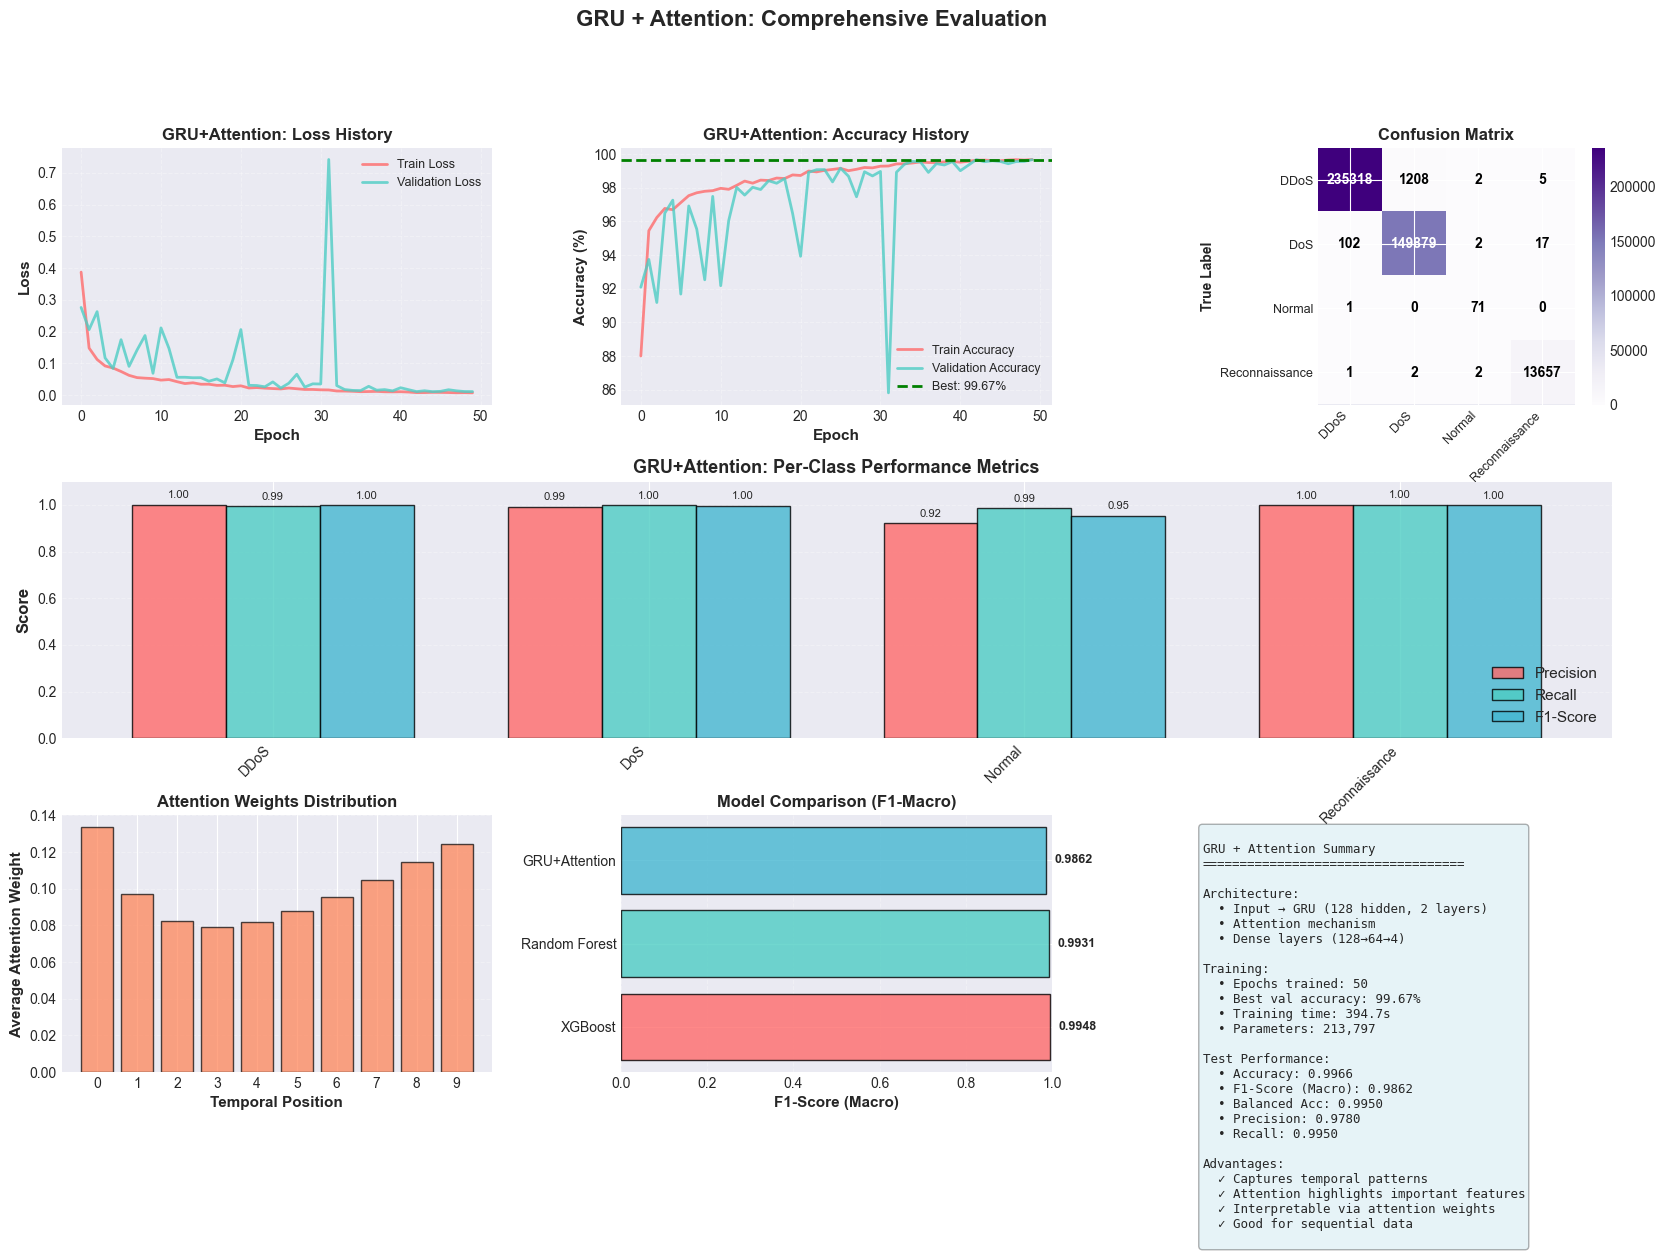


✓ GRU + Attention comprehensive visualization saved


In [21]:
# Detailed visualization for GRU + Attention
print("="*80)
print("DETAILED VISUALIZATION: GRU + ATTENTION")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training History - Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses_gru, label='Train Loss', linewidth=2, color='#FF6B6B', alpha=0.8)
ax1.plot(val_losses_gru, label='Validation Loss', linewidth=2, color='#4ECDC4', alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('GRU+Attention: Loss History', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')

# 2. Training History - Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(train_accs_gru, label='Train Accuracy', linewidth=2, color='#FF6B6B', alpha=0.8)
ax2.plot(val_accs_gru, label='Validation Accuracy', linewidth=2, color='#4ECDC4', alpha=0.8)
ax2.axhline(y=best_val_acc, color='green', linestyle='--', linewidth=2, label=f'Best: {best_val_acc:.2f}%')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax2. set_title('GRU+Attention: Accuracy History', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')

# 3.  Confusion Matrix
ax3 = fig. add_subplot(gs[0, 2])
im = ax3.imshow(cm_gru, interpolation='nearest', cmap='Purples')
ax3.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(le_target.classes_))
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3. set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=9)
ax3.set_yticklabels(le_target.classes_, fontsize=9)

thresh = cm_gru.max() / 2.
for i in range(cm_gru.shape[0]):
    for j in range(cm_gru.shape[1]):
        ax3.text(j, i, format(cm_gru[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_gru[i, j] > thresh else "black",
                fontsize=10, fontweight='bold')

ax3.set_ylabel('True Label', fontsize=10, fontweight='bold')
ax3.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

# 4.  Per-Class Metrics
ax4 = fig.add_subplot(gs[1, :])
precision_per_class = precision_score(y_test, y_pred_test_gru, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred_test_gru, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred_test_gru, average=None, zero_division=0)

x = np.arange(len(le_target.classes_))
width = 0.25

ax4.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8, color='#FF6B6B', edgecolor='black')
ax4.bar(x, recall_per_class, width, label='Recall', alpha=0.8, color='#4ECDC4', edgecolor='black')
ax4.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8, color='#45B7D1', edgecolor='black')

ax4.set_xlabel('Class', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('GRU+Attention: Per-Class Performance Metrics', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=10)
ax4.legend(fontsize=11, loc='lower right')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.set_ylim([0, 1.1])

# Add value labels on bars
for i, (p, r, f) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    ax4.text(i - width, p + 0.02, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
    ax4.text(i, r + 0.02, f'{r:.2f}', ha='center', va='bottom', fontsize=8)
    ax4.text(i + width, f + 0.02, f'{f:.2f}', ha='center', va='bottom', fontsize=8)

# 5.  Attention Weights Visualization (sample batch)
ax5 = fig.add_subplot(gs[2, 0])
avg_attention = attention_weights_all.mean(axis=0). squeeze()
positions = np.arange(len(avg_attention))
ax5.bar(positions, avg_attention, color='coral', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Temporal Position', fontsize=11, fontweight='bold')
ax5.set_ylabel('Average Attention Weight', fontsize=11, fontweight='bold')
ax5.set_title('Attention Weights Distribution', fontsize=12, fontweight='bold')
ax5.set_xticks(positions)
ax5.grid(True, alpha=0.3, axis='y', linestyle='--')

# 6. Model Comparison with others
ax6 = fig.add_subplot(gs[2, 1])
if len(all_results) > 1:
    comparison_df = pd.DataFrame(all_results)
    models_so_far = comparison_df['Model'].values
    f1_scores = comparison_df['Test_F1_Macro'].values
    
    colors_comp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    ax6.barh(range(len(models_so_far)), f1_scores, color=colors_comp[:len(models_so_far)], 
            alpha=0.8, edgecolor='black')
    ax6.set_yticks(range(len(models_so_far)))
    ax6.set_yticklabels(models_so_far, fontsize=10)
    ax6. set_xlabel('F1-Score (Macro)', fontsize=11, fontweight='bold')
    ax6.set_title('Model Comparison (F1-Macro)', fontsize=12, fontweight='bold')
    ax6.set_xlim([0, 1.0])
    ax6.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    for i, v in enumerate(f1_scores):
        ax6.text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
else:
    ax6.text(0.5, 0.5, 'Train other models\nfor comparison', 
            ha='center', va='center', fontsize=12, transform=ax6.transAxes)
    ax6.axis('off')

# 7.  Training Summary Stats
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_text = f"""
GRU + Attention Summary
{'='*35}

Architecture:
  • Input → GRU (128 hidden, 2 layers)
  • Attention mechanism
  • Dense layers (128→64→4)
  
Training:
  • Epochs trained: {len(train_losses_gru)}
  • Best val accuracy: {best_val_acc:.2f}%
  • Training time: {training_time_gru:.1f}s
  • Parameters: {total_params:,}
  
Test Performance:
  • Accuracy: {results_gru['Test_Acc']:.4f}
  • F1-Score (Macro): {results_gru['Test_F1_Macro']:.4f}
  • Balanced Acc: {results_gru['Test_Balanced_Acc']:.4f}
  • Precision: {results_gru['Test_Precision_Macro']:.4f}
  • Recall: {results_gru['Test_Recall_Macro']:.4f}

Advantages:
  ✓ Captures temporal patterns
  ✓ Attention highlights important features
  ✓ Interpretable via attention weights
  ✓ Good for sequential data
"""

ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes,
        fontsize=9, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('GRU + Attention: Comprehensive Evaluation', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('plots/09_gru_attention_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ GRU + Attention comprehensive visualization saved")

ATTENTION MECHANISM ANALYSIS

Analyzing attention patterns per class...


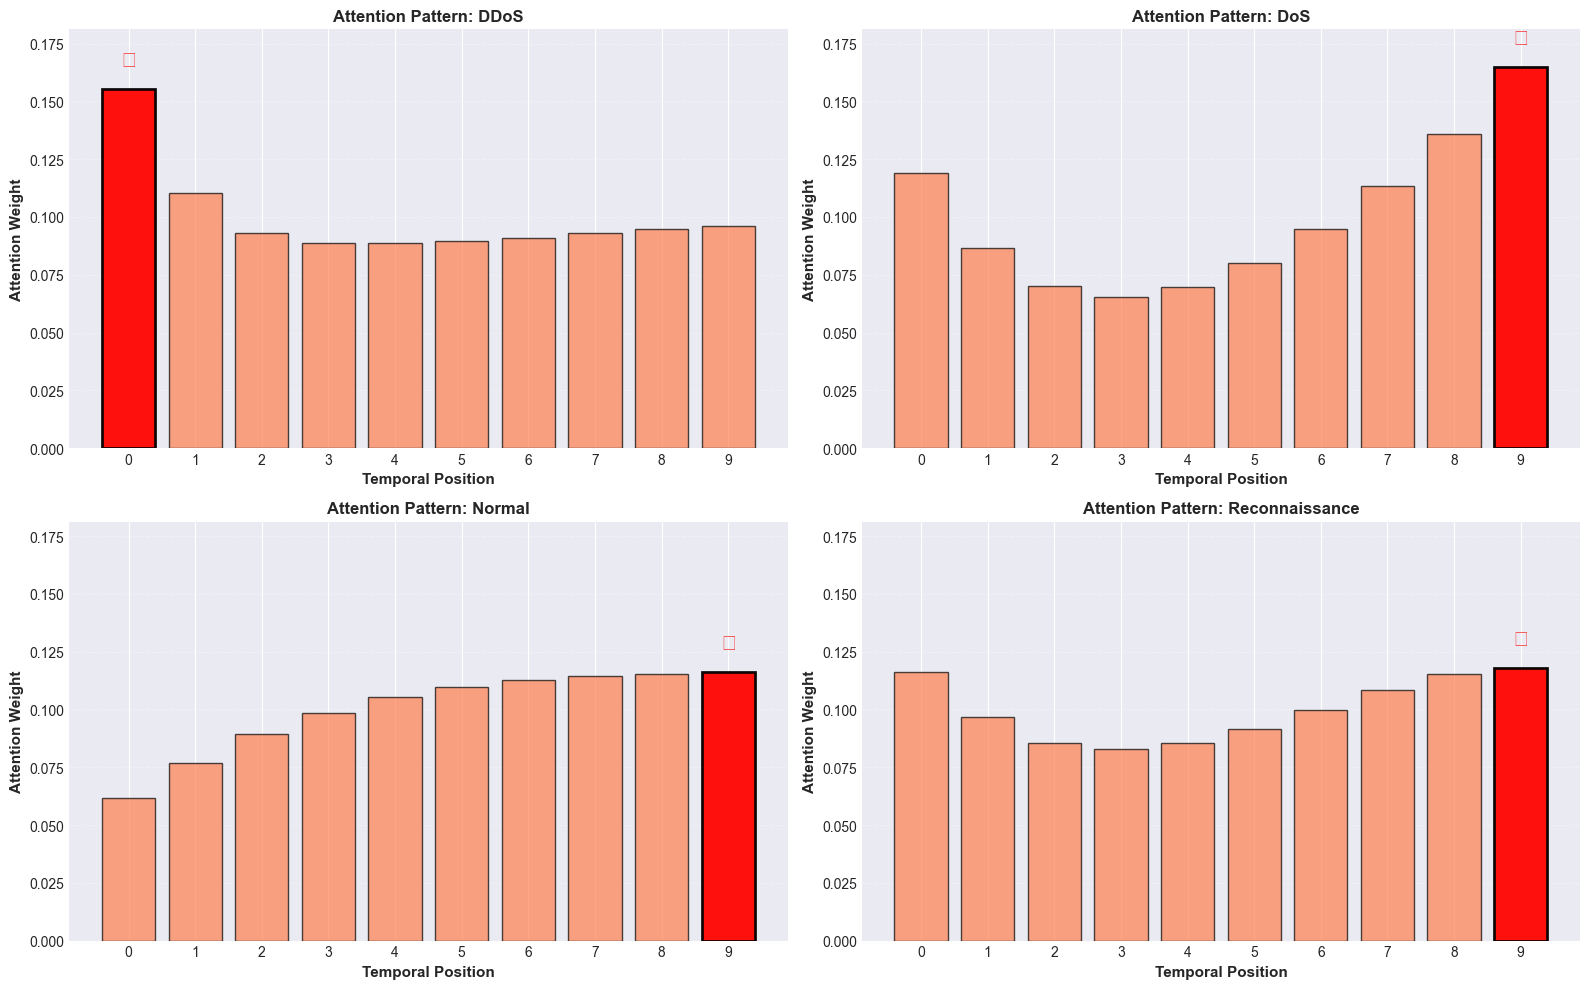


ATTENTION INSIGHTS:

DDoS:
  Most important position: 0 (weight: 0.1553)
  Average weight: 0.1000
  Weight range: [0.0885, 0.1553]
  Focus distribution: Distributed

DoS:
  Most important position: 9 (weight: 0.1647)
  Average weight: 0.1000
  Weight range: [0.0655, 0.1647]
  Focus distribution: Distributed

Normal:
  Most important position: 9 (weight: 0.1161)
  Average weight: 0.1000
  Weight range: [0.0616, 0.1161]
  Focus distribution: Distributed

Reconnaissance:
  Most important position: 9 (weight: 0.1177)
  Average weight: 0.1000
  Weight range: [0.0831, 0.1177]
  Focus distribution: Distributed

✓ Attention mechanism analysis completed


18936

In [22]:
# Detailed attention mechanism analysis
print("="*80)
print("ATTENTION MECHANISM ANALYSIS")
print("="*80)

# Get attention weights for a sample batch from each class
print("\nAnalyzing attention patterns per class...")

sample_attention_per_class = {}

for class_id in range(len(le_target.classes_)):
    class_name = le_target.classes_[class_id]
    
    # Get samples from this class
    class_indices = np.where(y_test == class_id)[0][:50]  # First 50 samples
    
    if len(class_indices) > 0:
        X_class_samples = torch.FloatTensor(X_test_minmax[class_indices]). to(device)
        
        with torch.no_grad():
            _, attention_weights = gru_model(X_class_samples)
        
        # Average attention across samples
        avg_attention = attention_weights.cpu().numpy().mean(axis=0). squeeze()
        sample_attention_per_class[class_name] = avg_attention

# Visualize attention patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, (class_name, attention) in enumerate(sample_attention_per_class.items()):
    positions = np.arange(len(attention))
    
    axes[idx].bar(positions, attention, color='coral', alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Temporal Position', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Attention Weight', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Attention Pattern: {class_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(positions)
    axes[idx].grid(True, alpha=0.3, axis='y', linestyle='--')
    axes[idx].set_ylim([0, max([max(att) for att in sample_attention_per_class.values()]) * 1.1])
    
    # Highlight most important position
    max_pos = np.argmax(attention)
    axes[idx].bar(max_pos, attention[max_pos], color='red', alpha=0.9, edgecolor='black', linewidth=2)
    axes[idx].text(max_pos, attention[max_pos] + 0.01, '★', ha='center', fontsize=16, color='red')

plt.tight_layout()
plt.savefig('plots/10_attention_patterns_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

# Print attention insights
print("\n" + "="*80)
print("ATTENTION INSIGHTS:")
print("="*80)

for class_name, attention in sample_attention_per_class.items():
    max_pos = np.argmax(attention)
    max_weight = attention[max_pos]
    min_weight = attention. min()
    avg_weight = attention.mean()
    
    print(f"\n{class_name}:")
    print(f"  Most important position: {max_pos} (weight: {max_weight:.4f})")
    print(f"  Average weight: {avg_weight:.4f}")
    print(f"  Weight range: [{min_weight:.4f}, {max_weight:.4f}]")
    print(f"  Focus distribution: {'Concentrated' if (max_weight / avg_weight) > 2 else 'Distributed'}")

print("\n✓ Attention mechanism analysis completed")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

## Lightweight CNN+ANN Hybrid Model

In [23]:
# Lightweight CNN+ANN Hybrid for IDS
print("="*80)
print("MODEL 3: Lightweight CNN+ANN Hybrid (Efficient Deep Learning)")
print("="*80)

print(f"\nWhy CNN+ANN Hybrid for IDS?")
print("  ✓ CNN extracts local feature patterns")
print("  ✓ ANN handles global feature relationships")
print("  ✓ Fewer parameters than pure CNN or RNN")
print("  ✓ Fast inference (important for real-time IDS)")
print("  ✓ Good for tabular network data")

class LightweightCNN_ANN(nn.Module):
    """
    Lightweight CNN+ANN hybrid for intrusion detection
    Architecture: 1D Conv → MaxPool → Flatten → Dense → Output
    """
    def __init__(self, input_dim, num_classes, dropout=0.3):
        super(LightweightCNN_ANN, self).__init__()
        
        # Reshape input for 1D convolution
        # Input: (batch, features) → (batch, 1, features)
        
        # CNN Block 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # CNN Block 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate flattened size
        # input_dim → conv1 → pool1 (÷2) → conv2 → pool2 (÷2)
        flattened_size = 64 * (input_dim // 4)
        
        # ANN Block (Dense layers)
        self.fc1 = nn.Linear(flattened_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn. Dropout(dropout)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.dropout2 = nn. Dropout(dropout)
        
        # Output layer
        self.fc3 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Reshape for 1D convolution: (batch, features) → (batch, 1, features)
        x = x. unsqueeze(1)
        
        # CNN Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # CNN Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # ANN Block
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self. dropout2(x)
        
        # Output
        x = self.fc3(x)
        
        return x


# Model configuration
input_dim = X_train_balanced.shape[1]
num_classes = len(le_target. classes_)
dropout = 0.3

print(f"\n{'='*80}")
print("Model Configuration:")
print(f"{'='*80}")
print(f"  Input dimension:     {input_dim}")
print(f"  Number of classes:   {num_classes}")
print(f"  Dropout:             {dropout}")
print(f"  Device:              {device}")

# Create model
cnn_ann_model = LightweightCNN_ANN(input_dim, num_classes, dropout).to(device)

# Count parameters
total_params = sum(p.numel() for p in cnn_ann_model.parameters())
trainable_params = sum(p. numel() for p in cnn_ann_model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters:      {total_params:,}")
print(f"  Trainable parameters:  {trainable_params:,}")
print(f"  Model size:            {total_params * 4 / 1024**2:.2f} MB")

# Model summary
print(f"\n{'='*80}")
print("Architecture Summary:")
print(f"{'='*80}")
print(f"  Input:  ({input_dim},) features")
print(f"  ↓")
print(f"  Conv1D: 1 → 32 channels, kernel=3")
print(f"  BatchNorm + ReLU + MaxPool(2)")
print(f"  ↓")
print(f"  Conv1D: 32 → 64 channels, kernel=3")
print(f"  BatchNorm + ReLU + MaxPool(2)")
print(f"  ↓")
print(f"  Flatten: {64 * (input_dim // 4):,} features")
print(f"  ↓")
print(f"  Dense:  → 128 neurons (BatchNorm + ReLU + Dropout)")
print(f"  Dense:  → 64 neurons (BatchNorm + ReLU + Dropout)")
print(f"  ↓")
print(f"  Output: {num_classes} classes")

print(f"\n✓ Lightweight CNN+ANN model created")

MODEL 3: Lightweight CNN+ANN Hybrid (Efficient Deep Learning)

Why CNN+ANN Hybrid for IDS?
  ✓ CNN extracts local feature patterns
  ✓ ANN handles global feature relationships
  ✓ Fewer parameters than pure CNN or RNN
  ✓ Fast inference (important for real-time IDS)
  ✓ Good for tabular network data

Model Configuration:
  Input dimension:     35
  Number of classes:   4
  Dropout:             0.3
  Device:              cuda

Model Statistics:
  Total parameters:      81,092
  Trainable parameters:  81,092
  Model size:            0.31 MB

Architecture Summary:
  Input:  (35,) features
  ↓
  Conv1D: 1 → 32 channels, kernel=3
  BatchNorm + ReLU + MaxPool(2)
  ↓
  Conv1D: 32 → 64 channels, kernel=3
  BatchNorm + ReLU + MaxPool(2)
  ↓
  Flatten: 512 features
  ↓
  Dense:  → 128 neurons (BatchNorm + ReLU + Dropout)
  Dense:  → 64 neurons (BatchNorm + ReLU + Dropout)
  ↓
  Output: 4 classes

✓ Lightweight CNN+ANN model created


TRAINING: Lightweight CNN+ANN MODEL (Memory Efficient)
Using batch size: 1024 (memory efficient)
  Train batches:   254
  Val batches:     390

Training Configuration:
  Epochs:          50
  Early stopping:  Patience = 10
  Batch size:      1024
  Learning rate:   0.001

Training Progress:
Epoch [  1/50] - Loss: 0.1676/0.1769 | Acc: 93.23%/95.05%
  → Best: 95.05% (saved)
  → Best: 95.78% (saved)
  → Best: 95.84% (saved)
Epoch [  5/50] - Loss: 0.0330/1.2056 | Acc: 98.37%/65.56%
  → Best: 97.48% (saved)
  → Best: 98.43% (saved)
Epoch [ 10/50] - Loss: 0.0255/0.0582 | Acc: 98.75%/97.74%
Epoch [ 15/50] - Loss: 0.0142/0.0730 | Acc: 99.34%/96.21%
  → Best: 99.53% (saved)
Epoch [ 20/50] - Loss: 0.0107/0.0731 | Acc: 99.53%/97.56%
  → Best: 99.61% (saved)
Epoch [ 25/50] - Loss: 0.0079/0.0475 | Acc: 99.67%/98.48%
  → Best: 99.64% (saved)
Epoch [ 30/50] - Loss: 0.0075/0.0160 | Acc: 99.67%/99.43%
  → Best: 99.71% (saved)
Epoch [ 35/50] - Loss: 0.0073/0.0290 | Acc: 99.68%/99.30%
Epoch [ 40/50] - Lo

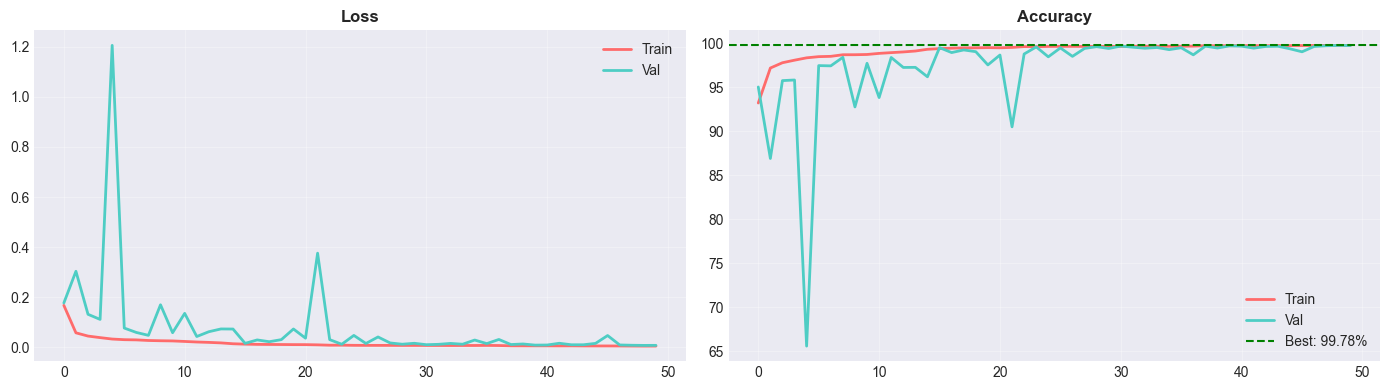


✓ CNN+ANN training completed
✓ Memory cleared


In [24]:
# Train Lightweight CNN+ANN with Memory Management
print("="*80)
print("TRAINING: Lightweight CNN+ANN MODEL (Memory Efficient)")
print("="*80)

# Clear memory before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Training configuration
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights_dict.values())).to(device))
optimizer = optim.Adam(cnn_ann_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler. ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Smaller batch size to prevent OOM
batch_size = 1024  # Reduced from 2048

print(f"Using batch size: {batch_size} (memory efficient)")

# Create data loaders with smaller batches
X_train_tensor = torch.FloatTensor(X_train_minmax_balanced)
y_train_tensor = torch.LongTensor(y_train_balanced)
X_val_tensor = torch.FloatTensor(X_val_minmax)
y_val_tensor = torch.LongTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"  Train batches:   {len(train_loader)}")
print(f"  Val batches:     {len(val_loader)}")

# Memory-efficient training function
def train_epoch_cnn(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
        try:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch. nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            # Clear batch from GPU memory
            del X_batch, y_batch, outputs, loss
            
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print(f'  ⚠ OOM at batch {batch_idx}, clearing cache.. .')
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
            else:
                raise e
    
    return total_loss / len(loader), 100 * correct / total

def validate_cnn(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch. max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum(). item()
            
            # Clear memory
            del X_batch, y_batch, outputs, loss
    
    return total_loss / len(loader), 100 * correct / total

# Training loop
num_epochs = 50
best_val_acc = 0
patience = 10
patience_counter = 0

train_losses_cnn = []
val_losses_cnn = []
train_accs_cnn = []
val_accs_cnn = []

print(f"\n{'='*80}")
print("Training Configuration:")
print(f"{'='*80}")
print(f"  Epochs:          {num_epochs}")
print(f"  Early stopping:  Patience = {patience}")
print(f"  Batch size:      {batch_size}")
print(f"  Learning rate:   0.001")

print(f"\n{'='*80}")
print("Training Progress:")
print(f"{'='*80}")

start_time = time.time()

try:
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch_cnn(cnn_ann_model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_cnn(cnn_ann_model, val_loader, criterion, device)
        
        # Store history
        train_losses_cnn. append(train_loss)
        val_losses_cnn.append(val_loss)
        train_accs_cnn.append(train_acc)
        val_accs_cnn.append(val_acc)
        
        # Scheduler
        scheduler.step(val_acc)
        
        # Print every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] - "
                  f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
                  f"Acc: {train_acc:.2f}%/{val_acc:.2f}%")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(cnn_ann_model.state_dict(), 'models/cnn_ann_best.pth')
            if (epoch + 1) % 5 != 0:
                print(f"  → Best: {best_val_acc:.2f}% (saved)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping at epoch {epoch+1}")
                print(f"  Best val acc: {best_val_acc:.2f}%")
                break
        
        # Clear memory every epoch
        if torch.cuda. is_available():
            torch. cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("Saving current state...")
    torch.save(cnn_ann_model.state_dict(), 'models/cnn_ann_last.pth')

training_time_cnn = time.time() - start_time

# Load best model
if os.path.exists('models/cnn_ann_best.pth'):
    cnn_ann_model.load_state_dict(torch.load('models/cnn_ann_best.pth'))
    print(f"\n✓ Best model loaded (Val Acc: {best_val_acc:.2f}%)")
else:
    print(f"\n⚠ Using current model state")

print(f"\n{'='*80}")
print(f"Training Summary:")
print(f"{'='*80}")
print(f"  Time:            {training_time_cnn:.2f}s ({training_time_cnn/60:.2f} min)")
print(f"  Epochs:          {len(train_losses_cnn)}/{num_epochs}")
print(f"  Best val acc:    {best_val_acc:.2f}%")
print(f"  Early stopped:   {'Yes' if patience_counter >= patience else 'No'}")

# Simple plot (memory efficient)
if len(train_losses_cnn) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].plot(train_losses_cnn, label='Train', color='#FF6B6B', linewidth=2)
    axes[0].plot(val_losses_cnn, label='Val', color='#4ECDC4', linewidth=2)
    axes[0].set_title('Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1]. plot(train_accs_cnn, label='Train', color='#FF6B6B', linewidth=2)
    axes[1].plot(val_accs_cnn, label='Val', color='#4ECDC4', linewidth=2)
    axes[1].axhline(best_val_acc, color='green', linestyle='--', label=f'Best: {best_val_acc:.2f}%')
    axes[1].set_title('Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/02_cnn_ann_training.png', dpi=200, bbox_inches='tight')
    plt.show()

# Clear memory
del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor
del train_dataset, val_dataset, train_loader, val_loader
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print("\n✓ CNN+ANN training completed")
print("✓ Memory cleared")

## Evaluate CNN+ANN Model

EVALUATION: CNN+ANN MODEL
Making predictions on test set...
✓ Test predictions completed (400,267 samples)
Making predictions on train set...
✓ Train predictions completed (260,000 samples)
Making predictions on validation set...
✓ Val predictions completed (399,199 samples)

CNN+ANN Results (on realistic test set):
  Model                    : CNN+ANN
  Train_Acc                : 0.9985
  Val_Acc                  : 0.9978
  Test_Acc                 : 0.9978
  Test_Precision_Macro     : 0.9850
  Test_Recall_Macro        : 0.9990
  Test_F1_Macro            : 0.9918
  Test_F1_Weighted         : 0.9978
  Test_Balanced_Acc        : 0.9990
  Training_Time            : 332.3729

Per-Class Performance:
                precision    recall  f1-score   support

          DDoS     0.9998    0.9965    0.9981    236533
           DoS     0.9947    0.9996    0.9972    150000
        Normal     0.9474    1.0000    0.9730        72
Reconnaissance     0.9980    1.0000    0.9990     13662

      accurac

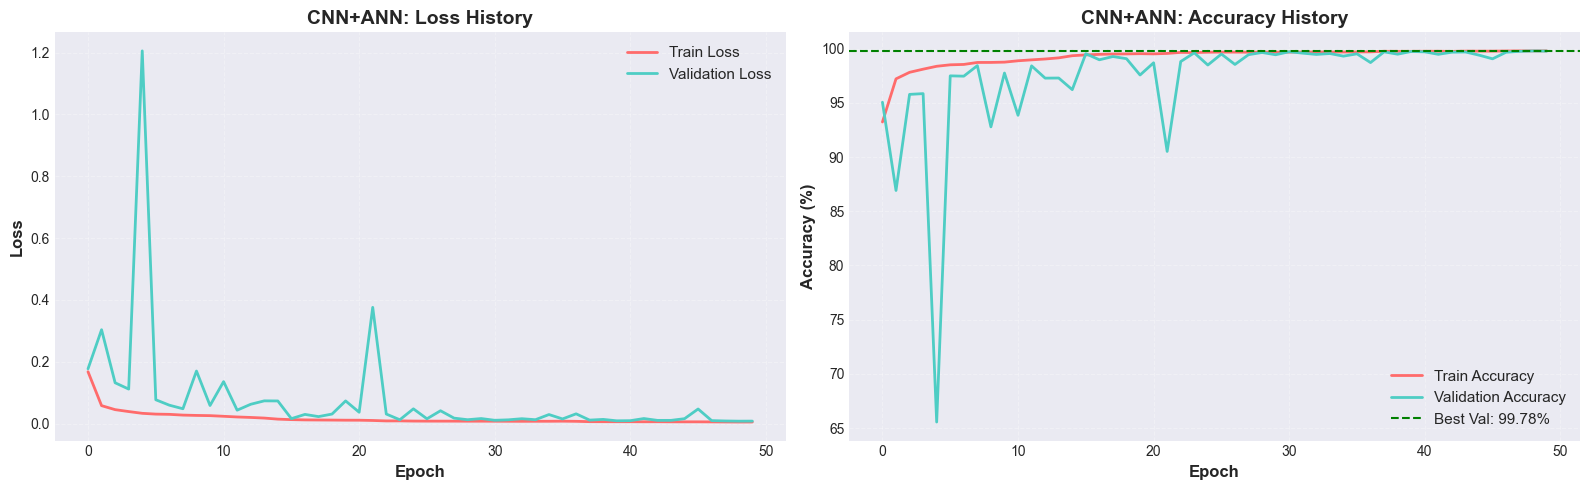


✓ CNN+ANN evaluation completed


In [29]:
# Evaluate CNN+ANN model
print("="*80)
print("EVALUATION: CNN+ANN MODEL")
print("="*80)

cnn_ann_model. eval()

# Create test loader for batch processing
X_test_tensor = torch.FloatTensor(X_test_minmax)
y_test_tensor = torch. LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)

print("Making predictions on test set...")

# Test predictions (batch processing to avoid OOM)
y_pred_test_cnn = []
y_proba_test_cnn = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = cnn_ann_model(X_batch)
        
        # Predictions
        _, predicted = torch. max(outputs, 1)
        y_pred_test_cnn.extend(predicted.cpu(). numpy())
        
        # Probabilities
        probas = torch.softmax(outputs, dim=1).cpu().numpy()
        y_proba_test_cnn. append(probas)
        
        # Clear memory
        del X_batch, outputs, predicted, probas

y_pred_test_cnn = np.array(y_pred_test_cnn)
y_proba_test_cnn = np.vstack(y_proba_test_cnn)

print(f"✓ Test predictions completed ({len(y_pred_test_cnn):,} samples)")

# Train predictions - recreate train dataset
print("Making predictions on train set...")
X_train_tensor = torch.FloatTensor(X_train_minmax_balanced)
y_train_tensor = torch.LongTensor(y_train_balanced)
train_dataset_eval = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_eval = DataLoader(train_dataset_eval, batch_size=1024, shuffle=False, num_workers=0)

y_pred_train_cnn = []

with torch.no_grad():
    for X_batch, _ in train_loader_eval:
        X_batch = X_batch. to(device)
        outputs = cnn_ann_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_train_cnn.extend(predicted. cpu().numpy())
        
        # Clear memory
        del X_batch, outputs, predicted

y_pred_train_cnn = np.array(y_pred_train_cnn)

print(f"✓ Train predictions completed ({len(y_pred_train_cnn):,} samples)")

# Val predictions - recreate val dataset
print("Making predictions on validation set...")
X_val_tensor = torch.FloatTensor(X_val_minmax)
y_val_tensor = torch.LongTensor(y_val)
val_dataset_eval = TensorDataset(X_val_tensor, y_val_tensor)
val_loader_eval = DataLoader(val_dataset_eval, batch_size=1024, shuffle=False, num_workers=0)

y_pred_val_cnn = []

with torch.no_grad():
    for X_batch, _ in val_loader_eval:
        X_batch = X_batch.to(device)
        outputs = cnn_ann_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_val_cnn.extend(predicted.cpu().numpy())
        
        # Clear memory
        del X_batch, outputs, predicted

y_pred_val_cnn = np. array(y_pred_val_cnn)

print(f"✓ Val predictions completed ({len(y_pred_val_cnn):,} samples)")

# Metrics
results_cnn = {
    'Model': 'CNN+ANN',
    'Train_Acc': accuracy_score(y_train_balanced, y_pred_train_cnn),
    'Val_Acc': accuracy_score(y_val, y_pred_val_cnn),
    'Test_Acc': accuracy_score(y_test, y_pred_test_cnn),
    'Test_Precision_Macro': precision_score(y_test, y_pred_test_cnn, average='macro', zero_division=0),
    'Test_Recall_Macro': recall_score(y_test, y_pred_test_cnn, average='macro', zero_division=0),
    'Test_F1_Macro': f1_score(y_test, y_pred_test_cnn, average='macro', zero_division=0),
    'Test_F1_Weighted': f1_score(y_test, y_pred_test_cnn, average='weighted', zero_division=0),
    'Test_Balanced_Acc': balanced_accuracy_score(y_test, y_pred_test_cnn),
    'Training_Time': training_time_cnn
}

print(f"\n{'='*80}")
print("CNN+ANN Results (on realistic test set):")
print(f"{'='*80}")
for key, value in results_cnn. items():
    if isinstance(value, (int, float)) and key != 'Model':
        print(f"  {key:25s}: {value:.4f}")
    else:
        print(f"  {key:25s}: {value}")

# Per-class metrics
print(f"\n{'='*80}")
print("Per-Class Performance:")
print(f"{'='*80}")
print(classification_report(y_test, y_pred_test_cnn, target_names=le_target.classes_, digits=4))

# Confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_test_cnn)
print(f"\nConfusion Matrix:")
print(cm_cnn)

# Per-class detection rates
print(f"\n{'='*80}")
print("ATTACK DETECTION RATES:")
print(f"{'='*80}")
for i, class_name in enumerate(le_target.classes_):
    class_mask = (y_test == i)
    if class_mask.sum() > 0:
        recall = recall_score(y_test == i, y_pred_test_cnn == i, zero_division=0)
        precision = precision_score(y_test == i, y_pred_test_cnn == i, zero_division=0)
        f1 = f1_score(y_test == i, y_pred_test_cnn == i, zero_division=0)
        support = class_mask. sum()
        print(f"{class_name:20s} - Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f} (n={support:,})")

# Save model
torch.save(cnn_ann_model.state_dict(), 'models/cnn_ann_model.pth')

# Add to results
all_results. append(results_cnn)

# Training curves (if history exists)
if len(train_losses_cnn) > 0 and len(val_losses_cnn) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(train_losses_cnn, label='Train Loss', linewidth=2, color='#FF6B6B')
    axes[0].plot(val_losses_cnn, label='Validation Loss', linewidth=2, color='#4ECDC4')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('CNN+ANN: Loss History', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0]. grid(True, alpha=0.3, linestyle='--')

    axes[1].plot(train_accs_cnn, label='Train Accuracy', linewidth=2, color='#FF6B6B')
    axes[1].plot(val_accs_cnn, label='Validation Accuracy', linewidth=2, color='#4ECDC4')
    if 'best_val_acc' in dir():
        axes[1].axhline(y=best_val_acc, color='green', linestyle='--', label=f'Best Val: {best_val_acc:.2f}%')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('CNN+ANN: Accuracy History', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('plots/02_cnn_ann_training.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\n⚠ Training history not available (model loaded from checkpoint)")

# Clear memory
del X_test_tensor, y_test_tensor, test_dataset, test_loader
del X_train_tensor, y_train_tensor, train_dataset_eval, train_loader_eval
del X_val_tensor, y_val_tensor, val_dataset_eval, val_loader_eval

if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print(f"\n✓ CNN+ANN evaluation completed")

## Compare All Models

COMPREHENSIVE MODEL COMPARISON - ALL 4 MODELS

All Models Performance Summary:
        Model  Train_Acc  Val_Acc  Test_Acc  Test_Precision_Macro  Test_Recall_Macro  Test_F1_Macro  Test_F1_Weighted  Test_Balanced_Acc  Training_Time
      XGBoost   1.000000 0.999992  0.999963              0.989865           0.999980       0.994821          0.999963           0.999980       4.536858
Random Forest   0.999946 0.999972  0.999943              0.986596           0.999969       0.993105          0.999943           0.999969       6.477651
GRU+Attention   0.997723 0.996651  0.996647              0.978005           0.994950       0.986204          0.996650           0.994950     394.685230
      CNN+ANN   0.998508 0.997796  0.997794              0.984967           0.999033       0.991820          0.997795           0.999033     332.372851

✓ Results saved to 'results/all_models_comparison.csv'


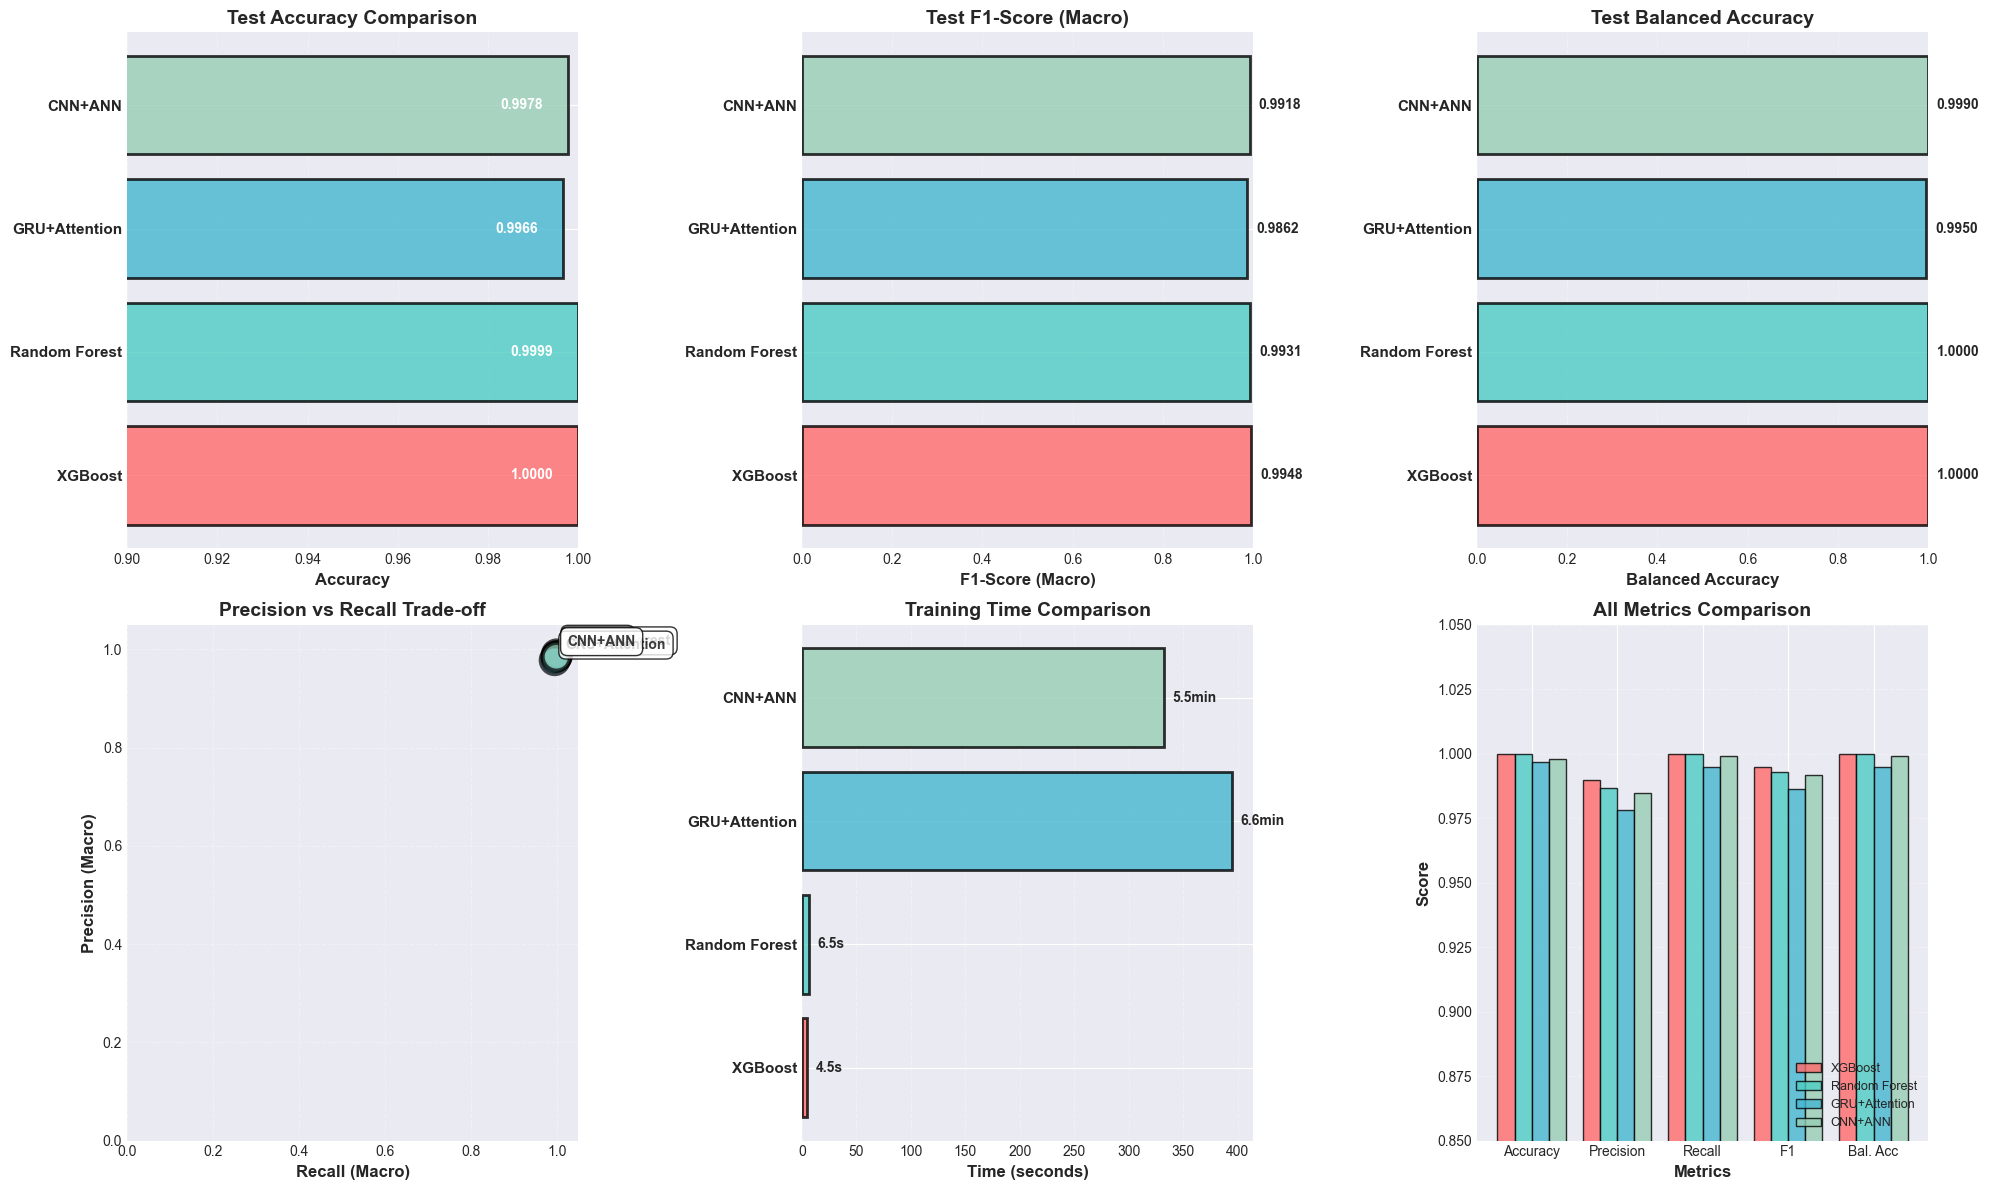


✓ Comprehensive comparison visualization saved


In [39]:
# Compare all models (XGBoost, Random Forest, GRU+Attention, CNN+ANN)
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON - ALL 4 MODELS")
print("="*80)

# Create results dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("All Models Performance Summary:")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('results/all_models_comparison.csv', index=False)
print("\n✓ Results saved to 'results/all_models_comparison.csv'")

# Visualization - Comprehensive comparison
fig, axes = plt. subplots(2, 3, figsize=(20, 12))

models = results_df['Model'].values
x_pos = np.arange(len(models))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Test Accuracy
axes[0, 0].barh(x_pos, results_df['Test_Acc']. values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(models, fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim([0.9, 1.0])
axes[0, 0].grid(True, alpha=0.3, axis='x', linestyle='--')
for i, v in enumerate(results_df['Test_Acc'].values):
    axes[0, 0].text(v - 0.015, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10, color='white')

# 2. Test F1-Score (Macro)
axes[0, 1].barh(x_pos, results_df['Test_F1_Macro'].values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 1]. set_yticks(x_pos)
axes[0, 1].set_yticklabels(models, fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Test F1-Score (Macro)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1.0])
axes[0, 1].grid(True, alpha=0.3, axis='x', linestyle='--')
for i, v in enumerate(results_df['Test_F1_Macro'].values):
    axes[0, 1].text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

# 3.  Balanced Accuracy
axes[0, 2].barh(x_pos, results_df['Test_Balanced_Acc'].values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 2].set_yticks(x_pos)
axes[0, 2].set_yticklabels(models, fontsize=11, fontweight='bold')
axes[0, 2]. set_xlabel('Balanced Accuracy', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Test Balanced Accuracy', fontsize=14, fontweight='bold')
axes[0, 2].set_xlim([0, 1.0])
axes[0, 2].grid(True, alpha=0.3, axis='x', linestyle='--')
for i, v in enumerate(results_df['Test_Balanced_Acc'].values):
    axes[0, 2].text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

# 4.  Precision vs Recall
axes[1, 0].scatter(results_df['Test_Recall_Macro'], results_df['Test_Precision_Macro'], 
                   s=400, c=colors[:len(models)], alpha=0.7, edgecolors='black', linewidth=3)
for i, model in enumerate(models):
    axes[1, 0].annotate(model, 
                       (results_df['Test_Recall_Macro']. iloc[i], results_df['Test_Precision_Macro']. iloc[i]),
                       fontsize=10, alpha=0.9, fontweight='bold',
                       xytext=(8, 8), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='black'))
axes[1, 0].set_xlabel('Recall (Macro)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precision (Macro)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].set_xlim([0, 1.05])
axes[1, 0].set_ylim([0, 1.05])

# 5. Training Time
axes[1, 1].barh(x_pos, results_df['Training_Time']. values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(models, fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x', linestyle='--')
for i, v in enumerate(results_df['Training_Time'].values):
    if v < 1:
        text = f'{v:.3f}s'
    elif v < 60:
        text = f'{v:.1f}s'
    else:
        text = f'{v/60:.1f}min'
    axes[1, 1]. text(v + max(results_df['Training_Time'].values)*0.02, i, 
                   text, va='center', fontweight='bold', fontsize=10)

# 6.  Overall Metrics Comparison (Grouped Bar)
ax6 = axes[1, 2]
metrics = ['Test_Acc', 'Test_Precision_Macro', 'Test_Recall_Macro', 'Test_F1_Macro', 'Test_Balanced_Acc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'Bal. Acc']

x = np.arange(len(metric_names))
width = 0.2

for i, model in enumerate(models):
    values = [results_df. loc[results_df['Model'] == model, metric].values[0] for metric in metrics]
    offset = (i - len(models)/2 + 0.5) * width
    ax6.bar(x + offset, values, width, label=model, alpha=0.8, edgecolor='black', color=colors[i])

ax6.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax6. set_ylabel('Score', fontsize=12, fontweight='bold')
ax6.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metric_names, fontsize=10)
ax6.legend(fontsize=9, loc='lower right')
ax6.grid(True, alpha=0.3, axis='y', linestyle='--')
ax6.set_ylim([0.85, 1.05])

plt.tight_layout()
plt. savefig('plots/05_all_models_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive comparison visualization saved")

## Per-Class Performance Comparison

PER-CLASS PERFORMANCE COMPARISON (ALL 4 MODELS)


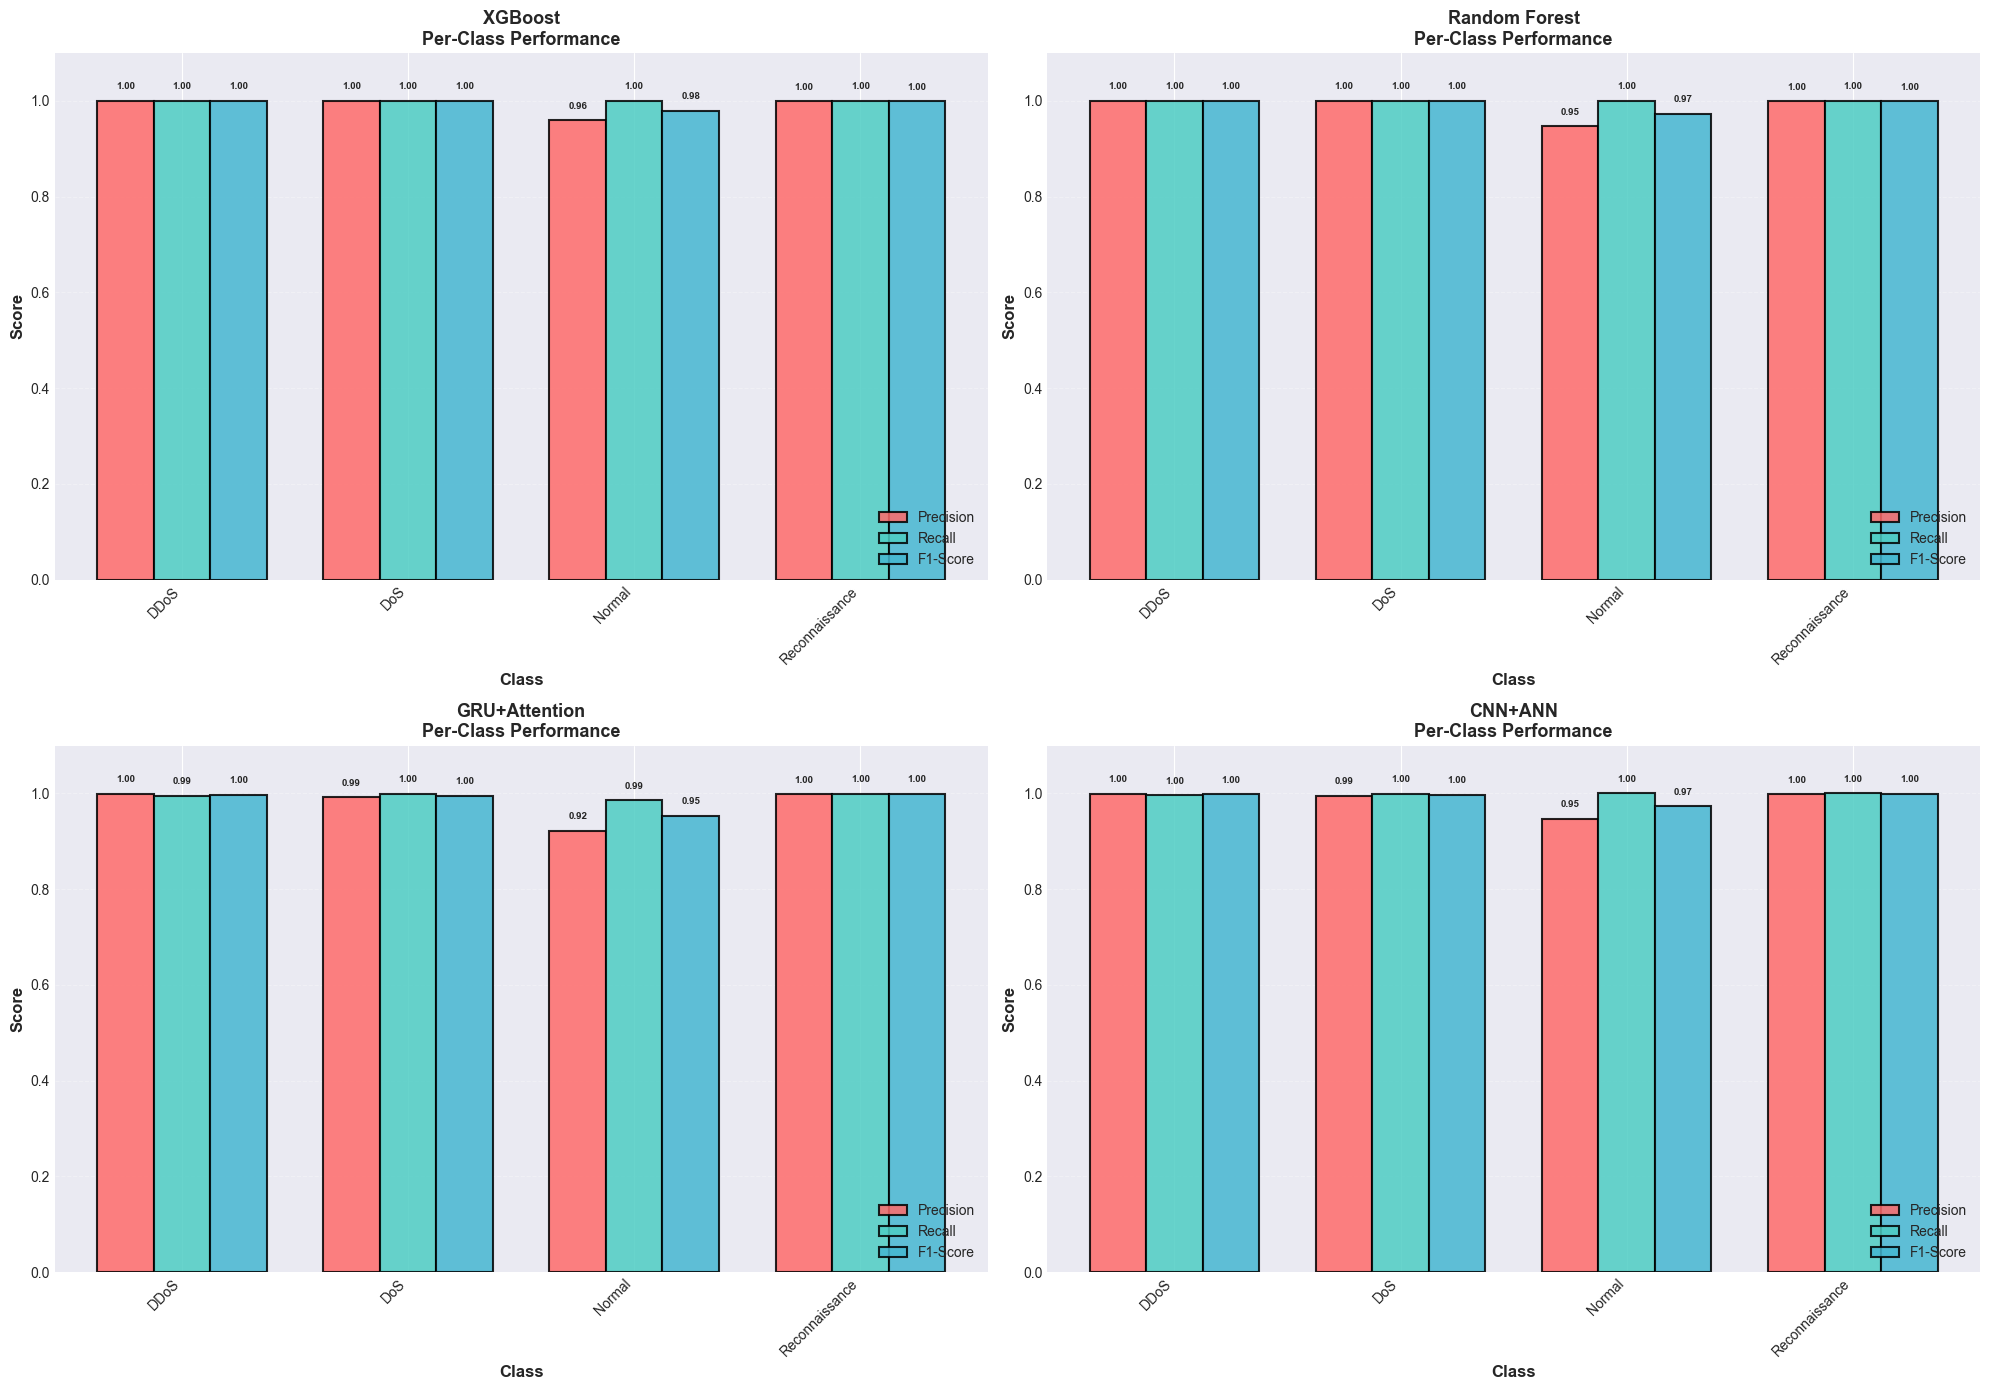


PER-CLASS F1-SCORE COMPARISON TABLE

          Class  XGBoost  Random Forest  GRU+Attention  CNN+ANN
           DDoS 0.999977       0.999968       0.997205 0.998139
            DoS 0.999970       0.999953       0.995579 0.997154
         Normal 0.979592       0.972973       0.953020 0.972973
 Reconnaissance 0.999744       0.999524       0.999012 0.999013
Average (Macro) 0.994821       0.993105       0.986204 0.991820

BEST MODEL PER CLASS:
  DDoS                : 🏆 XGBoost              (F1=1.0000)
  DoS                 : 🏆 XGBoost              (F1=1.0000)
  Normal              : 🏆 XGBoost              (F1=0.9796)
  Reconnaissance      : 🏆 XGBoost              (F1=0.9997)

✓ Per-class comparison table saved


In [42]:
# Per-class performance across all 4 models
print("="*80)
print("PER-CLASS PERFORMANCE COMPARISON (ALL 4 MODELS)")
print("="*80)

# Collect per-class metrics for all models
model_predictions = {
    'XGBoost': y_pred_test_xgb,
    'Random Forest': y_pred_test_rf,
    'GRU+Attention': y_pred_test_gru,
    'CNN+ANN': y_pred_test_cnn
}

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(model_predictions.items()):
    # Calculate per-class metrics
    precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    # Plot
    x = np.arange(len(le_target.classes_))
    width = 0.25
    
    bars1 = axes[idx].bar(x - width, precision_per_class, width, label='Precision', alpha=0.85, color='#FF6B6B', edgecolor='black', linewidth=1.5)
    bars2 = axes[idx].bar(x, recall_per_class, width, label='Recall', alpha=0.85, color='#4ECDC4', edgecolor='black', linewidth=1.5)
    bars3 = axes[idx].bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.85, color='#45B7D1', edgecolor='black', linewidth=1.5)
    
    axes[idx].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{model_name}\nPer-Class Performance', fontsize=13, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=10)
    axes[idx].legend(fontsize=10, loc='lower right')
    axes[idx]. grid(True, alpha=0.3, axis='y', linestyle='--')
    axes[idx].set_ylim([0, 1.1])
    
    # Add value labels on bars
    for bar_group in [bars1, bars2, bars3]:
        for bar in bar_group:
            height = bar.get_height()
            if height > 0.05:
                axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                             f'{height:.2f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()
plt. savefig('plots/06_per_class_performance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Create detailed per-class comparison table
print("\n" + "="*80)
print("PER-CLASS F1-SCORE COMPARISON TABLE")
print("="*80)

comparison_table = pd.DataFrame()
comparison_table['Class'] = le_target.classes_

for model_name, y_pred in model_predictions.items():
    f1_scores = f1_score(y_test, y_pred, average=None, zero_division=0)
    comparison_table[model_name] = f1_scores

# Add average row
avg_row = pd.DataFrame([['Average (Macro)'] + [comparison_table[col].mean() for col in comparison_table.columns[1:]]], 
                       columns=comparison_table.columns)
comparison_table = pd.concat([comparison_table, avg_row], ignore_index=True)

print("\n" + comparison_table.to_string(index=False))

# Highlight best model per class
print("\n" + "="*80)
print("BEST MODEL PER CLASS:")
print("="*80)

for i, class_name in enumerate(le_target.classes_):
    class_f1 = {}
    for model_name, y_pred in model_predictions.items():
        f1 = f1_score(y_test == i, y_pred == i, zero_division=0)
        class_f1[model_name] = f1
    
    best_model = max(class_f1, key=class_f1.get)
    best_f1 = class_f1[best_model]
    
    print(f"  {class_name:20s}: 🏆 {best_model:20s} (F1={best_f1:.4f})")

# Save comparison table
comparison_table.to_csv('results/per_class_f1_comparison.csv', index=False)
print("\n✓ Per-class comparison table saved")

CONFUSION MATRICES - ALL 4 MODELS


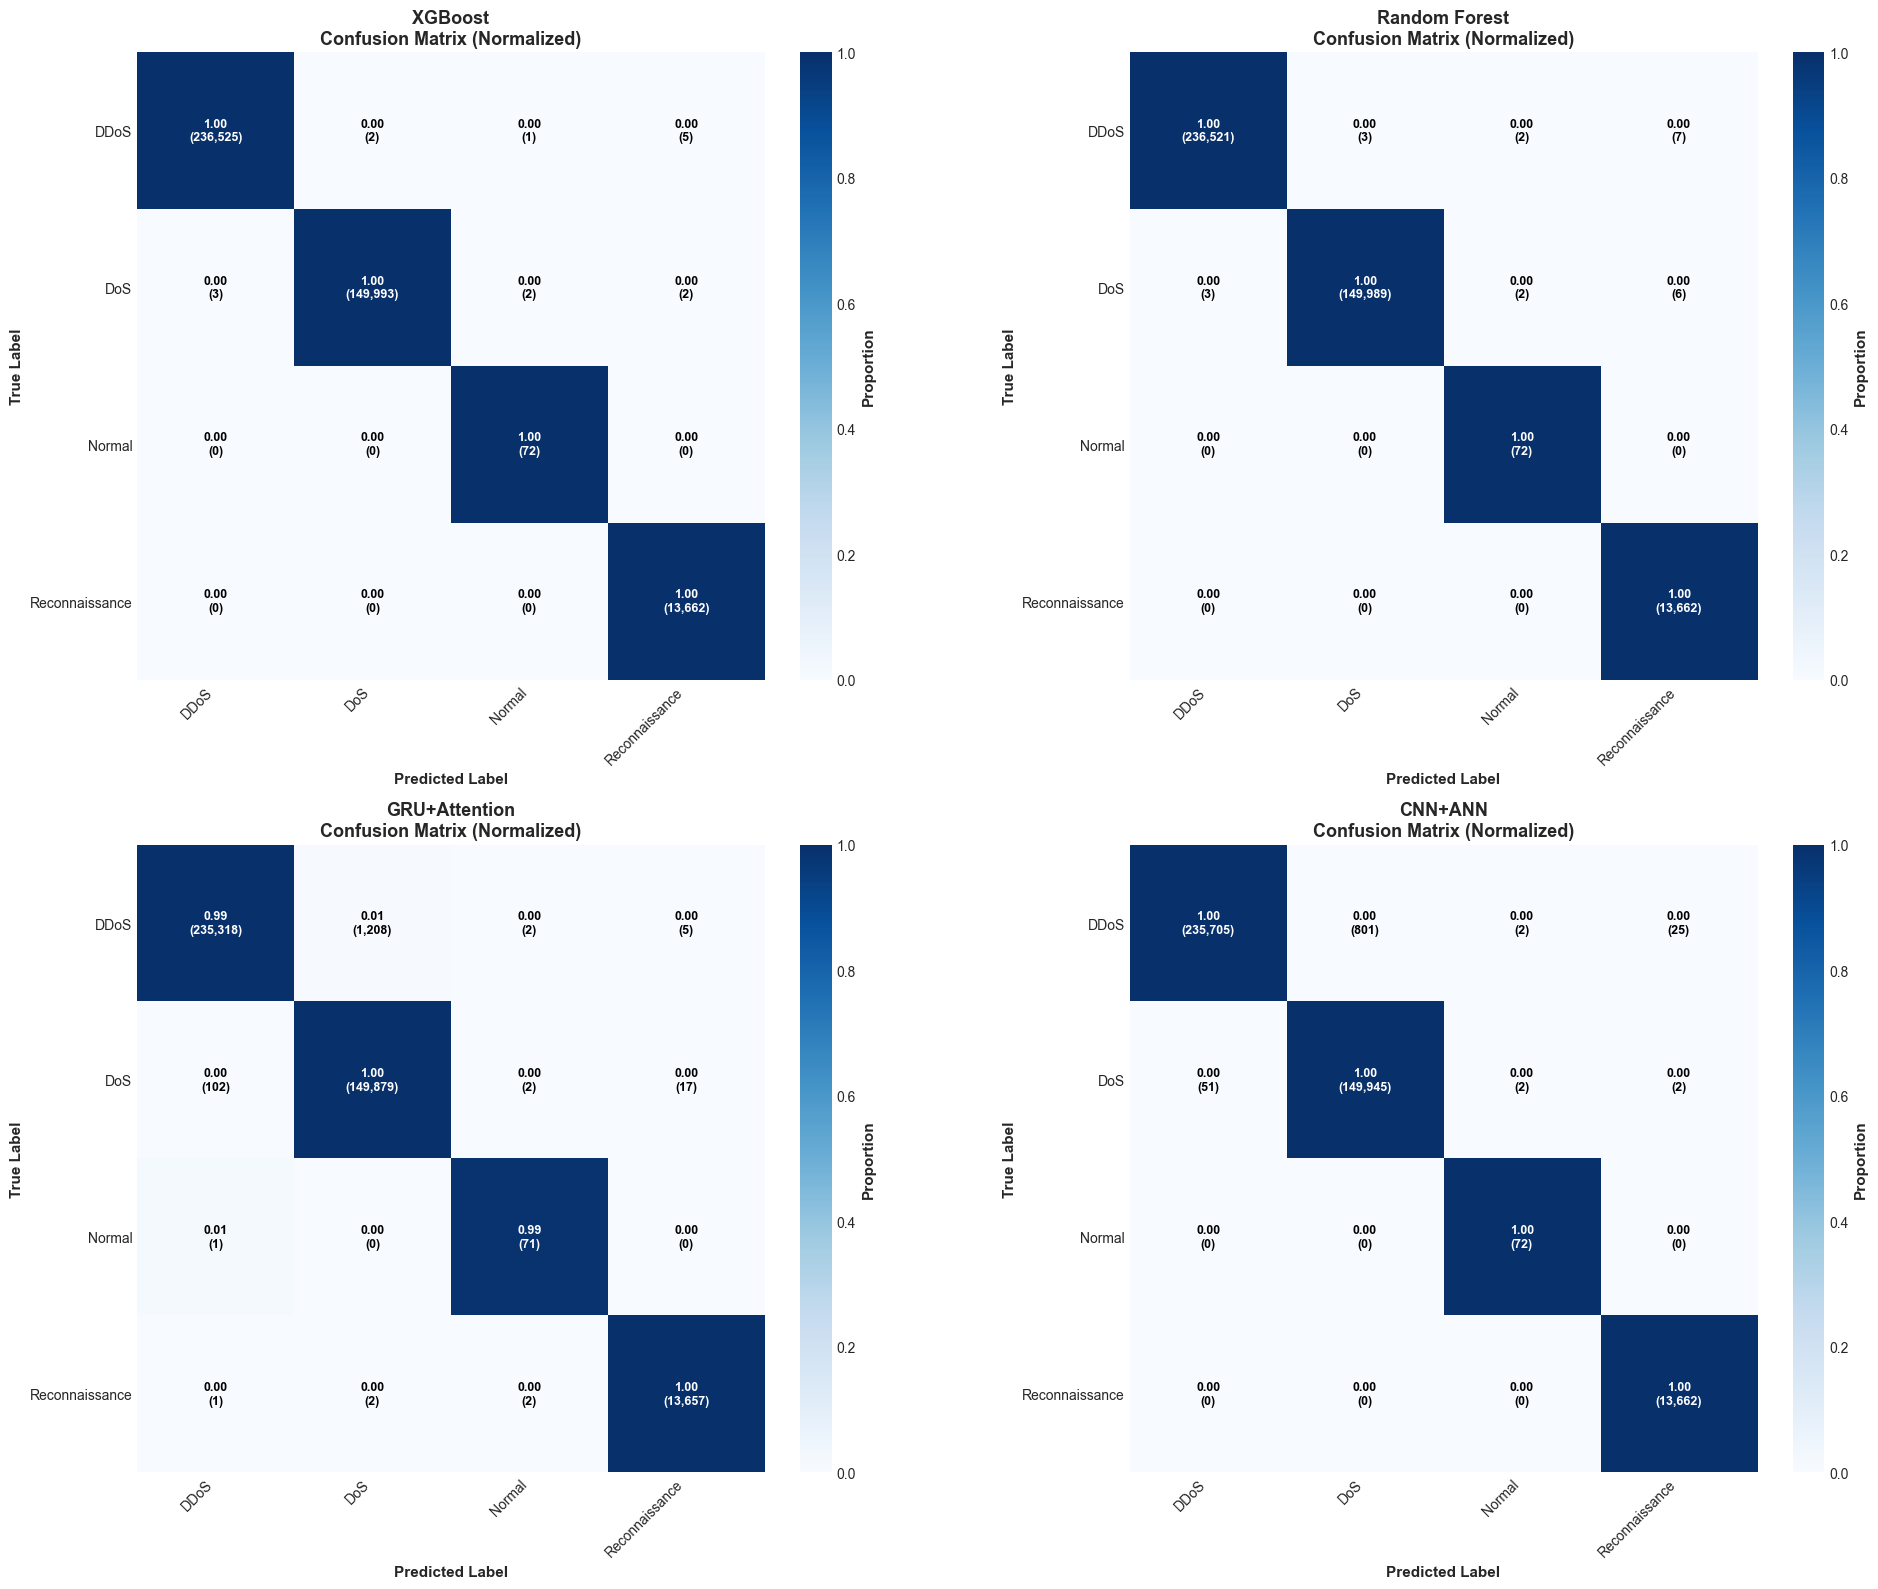


✓ Confusion matrices visualization saved

CONFUSION MATRIX STATISTICS

XGBoost:
  Total predictions: 400,267
  Correct predictions: 400,252
  Accuracy: 1.0000
    DDoS                : 1.0000 (236,525/236,533)
    DoS                 : 1.0000 (149,993/150,000)
    Normal              : 1.0000 (72/72)
    Reconnaissance      : 1.0000 (13,662/13,662)

Random Forest:
  Total predictions: 400,267
  Correct predictions: 400,244
  Accuracy: 0.9999
    DDoS                : 0.9999 (236,521/236,533)
    DoS                 : 0.9999 (149,989/150,000)
    Normal              : 1.0000 (72/72)
    Reconnaissance      : 1.0000 (13,662/13,662)

GRU+Attention:
  Total predictions: 400,267
  Correct predictions: 398,925
  Accuracy: 0.9966
    DDoS                : 0.9949 (235,318/236,533)
    DoS                 : 0.9992 (149,879/150,000)
    Normal              : 0.9861 (71/72)
    Reconnaissance      : 0.9996 (13,657/13,662)

CNN+ANN:
  Total predictions: 400,267
  Correct predictions: 399,384
  Ac

In [45]:
# Confusion matrices for all 4 models
print("="*80)
print("CONFUSION MATRICES - ALL 4 MODELS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

confusion_matrices = [
    (cm_xgb, 'XGBoost', '#FF6B6B'),
    (cm_rf, 'Random Forest', '#4ECDC4'),
    (cm_gru, 'GRU+Attention', '#9B59B6'),
    (cm_cnn, 'CNN+ANN', '#45B7D1')
]

for idx, (cm, model_name, color) in enumerate(confusion_matrices):
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = axes[idx].imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    axes[idx].set_title(f'{model_name}\nConfusion Matrix (Normalized)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt. colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar. set_label('Proportion', fontsize=11, fontweight='bold')
    
    # Add labels
    tick_marks = np.arange(len(le_target.classes_))
    axes[idx].set_xticks(tick_marks)
    axes[idx].set_yticks(tick_marks)
    axes[idx].set_xticklabels(le_target.classes_, rotation=45, ha='right', fontsize=10)
    axes[idx].set_yticklabels(le_target.classes_, fontsize=10)
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
            axes[idx].text(j, i, f'{cm_normalized[i, j]:.2f}\n({cm[i, j]:,})',
                         ha="center", va="center", color=text_color,
                         fontsize=9, fontweight='bold')
    
    axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.savefig('plots/07_confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices visualization saved")

# Print confusion matrix statistics
print("\n" + "="*80)
print("CONFUSION MATRIX STATISTICS")
print("="*80)

for model_name, y_pred in model_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate diagonal accuracy (correctly classified)
    diagonal_sum = np.trace(cm)
    total_sum = cm.sum()
    accuracy = diagonal_sum / total_sum
    
    print(f"\n{model_name}:")
    print(f"  Total predictions: {total_sum:,}")
    print(f"  Correct predictions: {diagonal_sum:,}")
    print(f"  Accuracy: {accuracy:.4f}")
    
    # Per-class accuracy
    for i, class_name in enumerate(le_target.classes_):
        class_total = cm[i, :].sum()
        class_correct = cm[i, i]
        class_acc = class_correct / class_total if class_total > 0 else 0
        print(f"    {class_name:20s}: {class_acc:.4f} ({class_correct:,}/{class_total:,})")

ROC CURVES (One-vs-Rest) - ALL 4 MODELS


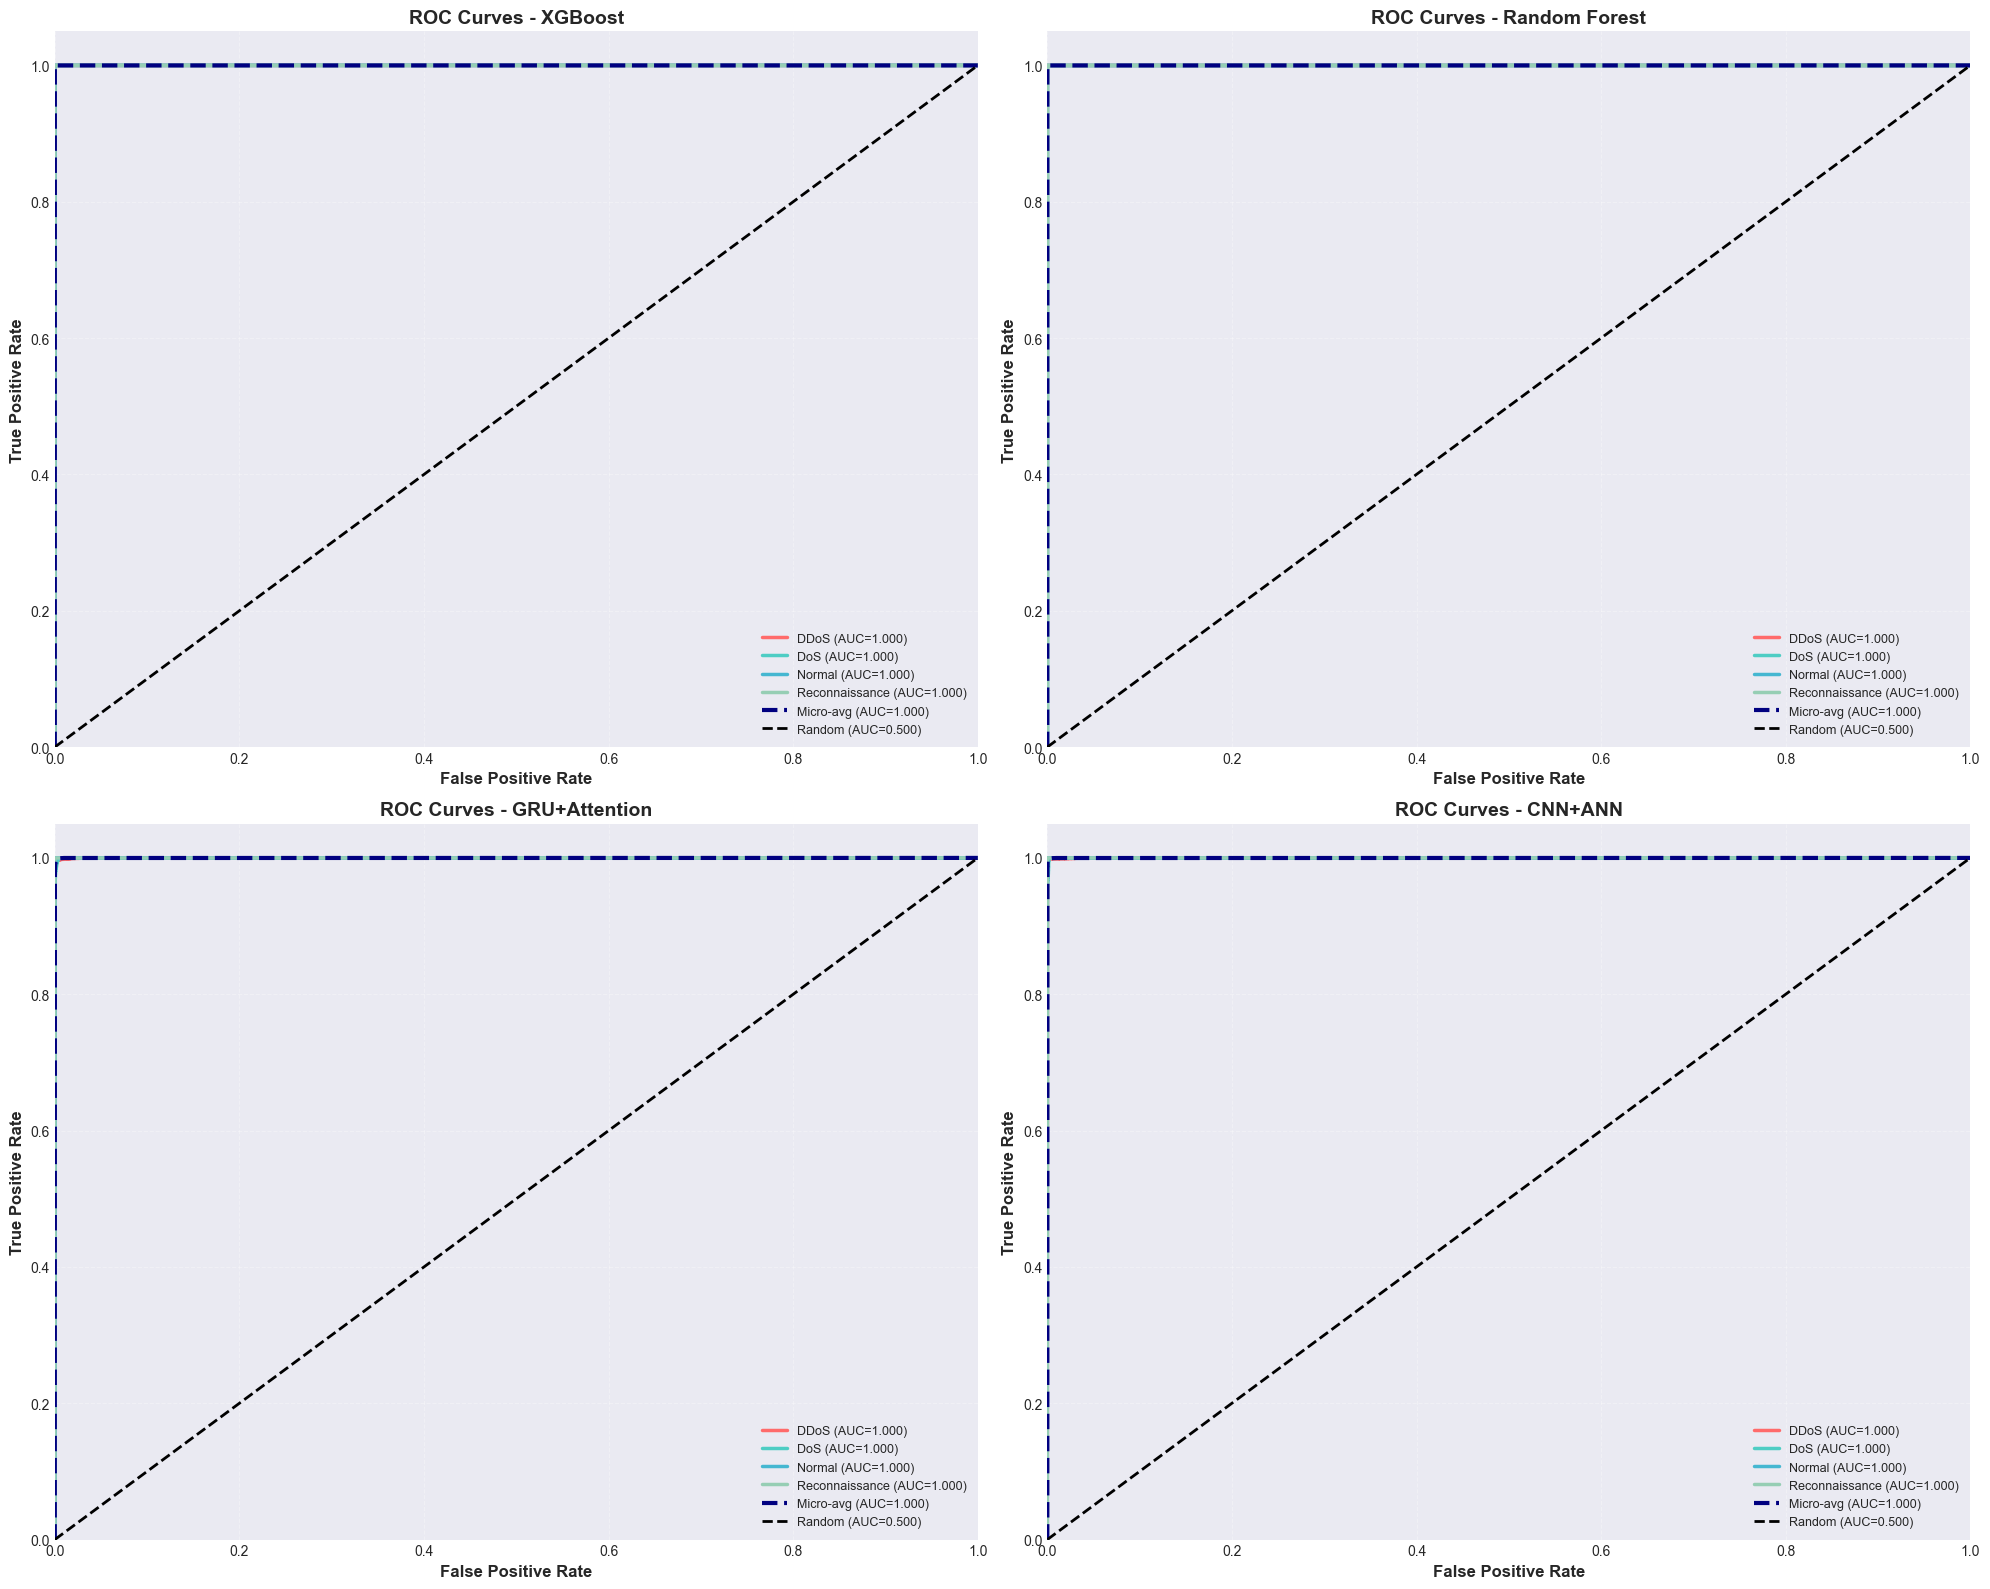


ROC-AUC SCORES SUMMARY

XGBoost:
  Macro-average AUC: 1.0000
  Micro-average AUC: 1.0000
  Per-class AUC:
    DDoS                : 1.0000
    DoS                 : 1.0000
    Normal              : 1.0000
    Reconnaissance      : 1.0000

Random Forest:
  Macro-average AUC: 1.0000
  Micro-average AUC: 1.0000
  Per-class AUC:
    DDoS                : 1.0000
    DoS                 : 1.0000
    Normal              : 1.0000
    Reconnaissance      : 1.0000

GRU+Attention:
  Macro-average AUC: 1.0000
  Micro-average AUC: 1.0000
  Per-class AUC:
    DDoS                : 0.9999
    DoS                 : 0.9999
    Normal              : 1.0000
    Reconnaissance      : 1.0000

CNN+ANN:
  Macro-average AUC: 1.0000
  Micro-average AUC: 1.0000
  Per-class AUC:
    DDoS                : 0.9999
    DoS                 : 0.9999
    Normal              : 1.0000
    Reconnaissance      : 1.0000

✓ ROC curves and AUC summary saved


In [48]:
# ROC Curves for all 4 models (One-vs-Rest)
print("="*80)
print("ROC CURVES (One-vs-Rest) - ALL 4 MODELS")
print("="*80)

from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_test, classes=range(len(le_target.classes_)))
n_classes = y_test_bin.shape[1]

# Collect probabilities
model_probas = {
    'XGBoost': y_proba_test_xgb,
    'Random Forest': y_proba_test_rf,
    'GRU+Attention': y_proba_test_gru,
    'CNN+ANN': y_proba_test_cnn
}

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])

for idx, (model_name, y_proba) in enumerate(model_probas.items()):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves for each class
    colors_class = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    for i, color in zip(range(n_classes), colors_class):
        axes[idx].plot(fpr[i], tpr[i], color=color, lw=2.5,
                      label=f'{le_target. classes_[i]} (AUC={roc_auc[i]:.3f})')
    
    # Plot micro-average
    axes[idx].plot(fpr["micro"], tpr["micro"], color='navy', lw=3, linestyle='--',
                  label=f'Micro-avg (AUC={roc_auc["micro"]:.3f})')
    
    # Plot random baseline
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.500)')
    
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    axes[idx].legend(loc="lower right", fontsize=9)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/08_roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute average AUC for each model
print("\n" + "="*80)
print("ROC-AUC SCORES SUMMARY")
print("="*80)

auc_summary = []

for model_name, y_proba in model_probas.items():
    auc_scores = []
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        auc_scores.append(auc(fpr, tpr))
    
    # Micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro-average
    auc_macro = np.mean(auc_scores)
    
    auc_summary.append({
        'Model': model_name,
        'Macro_AUC': auc_macro,
        'Micro_AUC': auc_micro
    })
    
    print(f"\n{model_name}:")
    print(f"  Macro-average AUC: {auc_macro:.4f}")
    print(f"  Micro-average AUC: {auc_micro:.4f}")
    print(f"  Per-class AUC:")
    for i, class_name in enumerate(le_target.classes_):
        print(f"    {class_name:20s}: {auc_scores[i]:.4f}")

# Save AUC summary
auc_summary_df = pd. DataFrame(auc_summary)
auc_summary_df.to_csv('results/auc_summary.csv', index=False)

print("\n✓ ROC curves and AUC summary saved")

MODEL RANKING & BEST MODEL SELECTION

RANKINGS BY DIFFERENT CRITERIA:

📊 F1-Score (Macro):
------------------------------------------------------------
  🥇 1. XGBoost             : 0.9948
  🥈 2. Random Forest       : 0.9931
  🥉 3. CNN+ANN             : 0.9918
     4. GRU+Attention       : 0.9862

📊 Balanced Accuracy:
------------------------------------------------------------
  🥇 1. XGBoost             : 1.0000
  🥈 2. Random Forest       : 1.0000
  🥉 3. CNN+ANN             : 0.9990
     4. GRU+Attention       : 0.9950

📊 Overall Accuracy:
------------------------------------------------------------
  🥇 1. XGBoost             : 1.0000
  🥈 2. Random Forest       : 0.9999
  🥉 3. CNN+ANN             : 0.9978
     4. GRU+Attention       : 0.9966

📊 Precision (Macro):
------------------------------------------------------------
  🥇 1. XGBoost             : 0.9899
  🥈 2. Random Forest       : 0.9866
  🥉 3. CNN+ANN             : 0.9850
     4. GRU+Attention       : 0.9780

📊 Recall (Macro):
-

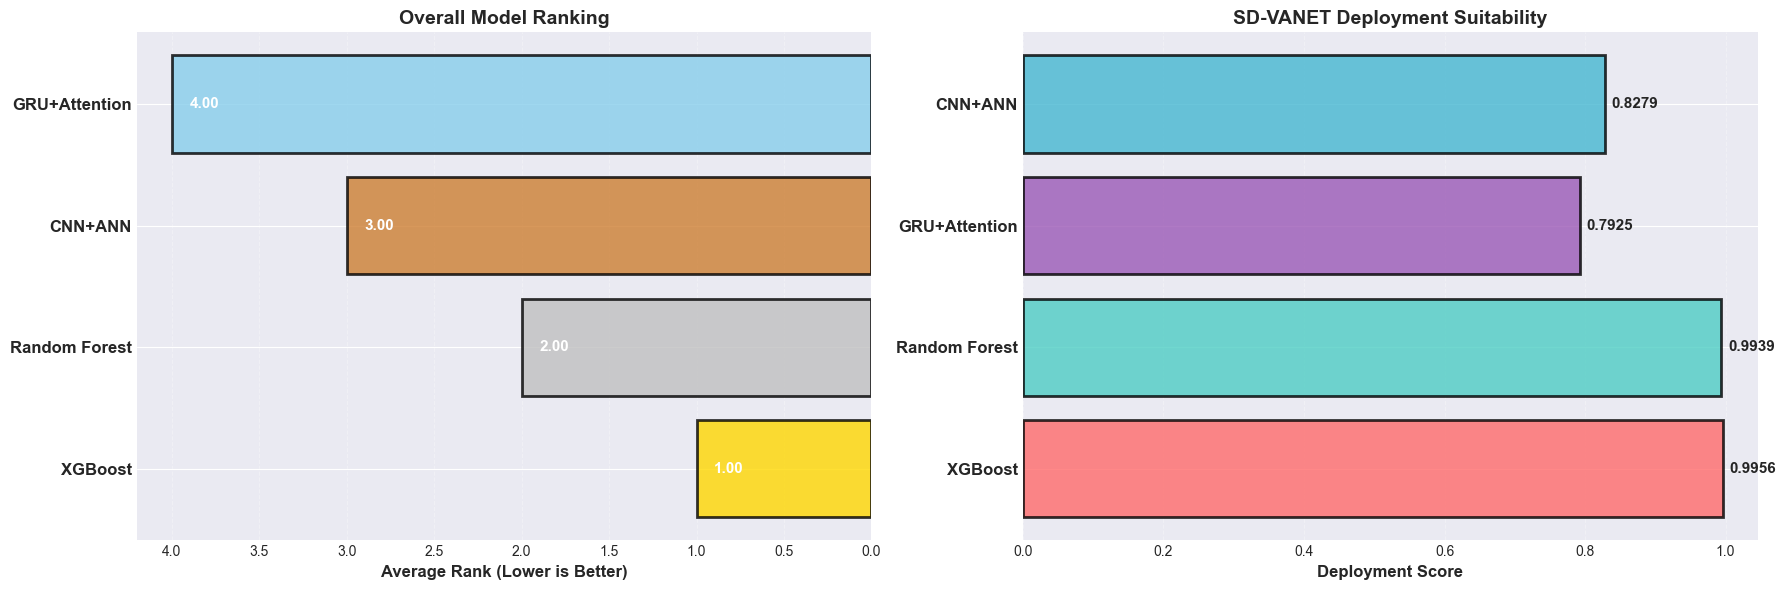


RECOMMENDATION FOR SD-VANET IDS:

✅ PRIMARY: XGBoost
   - Best balance of accuracy, speed, and deployment feasibility
   - Deployment Score: 0.9956

✅ ALTERNATIVE: XGBoost
   - Highest F1-Score (best overall performance)
   - F1-Score: 0.9948

MODEL COMPARISON SUMMARY:

        Model  Test_Acc  Test_F1_Macro  Test_Balanced_Acc  Test_Precision_Macro  Test_Recall_Macro  Training_Time  Deployment_Score
      XGBoost  0.999963       0.994821           0.999980              0.989865           0.999980       4.536858          0.995621
Random Forest  0.999943       0.993105           0.999969              0.986596           0.999969       6.477651          0.993947
      CNN+ANN  0.997794       0.991820           0.999033              0.984967           0.999033     332.372851          0.827917
GRU+Attention  0.996647       0.986204           0.994950              0.978005           0.994950     394.685230          0.792462

KEY INSIGHTS:
  🎯 Best Accuracy:       XGBoost
  🎯 Best F1-Score:  

In [56]:
# Model ranking and best model selection
print("="*80)
print("MODEL RANKING & BEST MODEL SELECTION")
print("="*80)

# Rank by different metrics
ranking_metrics = [
    ('Test_F1_Macro', 'F1-Score (Macro)', False),
    ('Test_Balanced_Acc', 'Balanced Accuracy', False),
    ('Test_Acc', 'Overall Accuracy', False),
    ('Test_Precision_Macro', 'Precision (Macro)', False),
    ('Test_Recall_Macro', 'Recall (Macro)', False),
    ('Training_Time', 'Training Time', True)
]

print("\n" + "="*80)
print("RANKINGS BY DIFFERENT CRITERIA:")
print("="*80)

ranking_summary = {}

for metric, title, ascending in ranking_metrics:
    ranked = results_df.sort_values(metric, ascending=ascending)
    
    print(f"\n📊 {title}:")
    print("-" * 60)
    
    for rank, (idx, row) in enumerate(ranked. iterrows(), 1):
        value = row[metric]
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        
        if metric == 'Training_Time':
            if value < 60:
                print(f"  {medal} {rank}. {row['Model']:20s}: {value:8.2f}s")
            else:
                print(f"  {medal} {rank}.  {row['Model']:20s}: {value/60:8.2f}min")
        else:
            print(f"  {medal} {rank}. {row['Model']:20s}: {value:.4f}")
        
        # Store ranking
        if row['Model'] not in ranking_summary:
            ranking_summary[row['Model']] = []
        ranking_summary[row['Model']].append(rank)

# Overall ranking (average rank across all metrics)
print("\n" + "="*80)
print("OVERALL RANKING (Average Rank):")
print("="*80)

overall_ranking = []
for model, ranks in ranking_summary.items():
    avg_rank = np.mean(ranks)
    overall_ranking.append((model, avg_rank, ranks))

overall_ranking. sort(key=lambda x: x[1])

for rank, (model, avg_rank, ranks) in enumerate(overall_ranking, 1):
    medal = "🏆" if rank == 1 else "🥇" if rank == 2 else "🥈" if rank == 3 else "🥉"
    print(f"  {medal} {rank}. {model:20s}: Avg Rank = {avg_rank:.2f}")
    print(f"       Individual ranks: {ranks}")

# Best overall model (by F1-Macro)
best_idx = results_df['Test_F1_Macro'].idxmax()
best_model = results_df. loc[best_idx]

print("\n" + "="*80)
print(f"🏆 BEST OVERALL MODEL (F1-Macro): {best_model['Model']}")
print("="*80)
print(f"  Test Accuracy:           {best_model['Test_Acc']:.4f}")
print(f"  Test F1-Score (Macro):   {best_model['Test_F1_Macro']:.4f}")
print(f"  Test F1-Score (Weighted):{best_model['Test_F1_Weighted']:.4f}")
print(f"  Test Balanced Accuracy:  {best_model['Test_Balanced_Acc']:.4f}")
print(f"  Test Precision (Macro):  {best_model['Test_Precision_Macro']:.4f}")
print(f"  Test Recall (Macro):     {best_model['Test_Recall_Macro']:.4f}")
print(f"  Training Time:           {best_model['Training_Time']:.2f}s")

# Best for deployment (balance of performance and speed)
print("\n" + "="*80)
print("DEPLOYMENT SCORE (Performance + Speed + Simplicity)")
print("="*80)

results_df['Deployment_Score'] = (
    results_df['Test_F1_Macro'] * 0.4 +  # 40% weight on F1
    results_df['Test_Balanced_Acc'] * 0.3 +  # 30% weight on balanced accuracy
    (1 - results_df['Training_Time'] / results_df['Training_Time']. max()) * 0.2 +  # 20% speed
    results_df['Test_Recall_Macro'] * 0.1  # 10% recall (important for IDS)
)

best_deployment_idx = results_df['Deployment_Score'].idxmax()
best_deployment_model = results_df.loc[best_deployment_idx]

print(f"\n🚀 BEST FOR SD-VANET DEPLOYMENT: {best_deployment_model['Model']}")
print("="*80)
print(f"  Deployment Score:        {best_deployment_model['Deployment_Score']:.4f}")
print(f"  Test F1-Score (Macro):   {best_deployment_model['Test_F1_Macro']:.4f}")
print(f"  Test Recall (Macro):     {best_deployment_model['Test_Recall_Macro']:.4f}")
print(f"  Training Time:           {best_deployment_model['Training_Time']:.2f}s")
print(f"  Balance: High performance + Fast training + Good recall")

# Visualization of rankings
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Define colors as list (NOT cycle)
colors_list = ['#FF6B6B', '#4ECDC4', '#9B59B6', '#45B7D1']
colors_ranked = ['#FFD700', '#C0C0C0', '#CD7F32', '#87CEEB']

# 1. Overall ranking visualization
models_ranked = [x[0] for x in overall_ranking]
avg_ranks = [x[1] for x in overall_ranking]

axes[0].barh(range(len(models_ranked)), avg_ranks, color=colors_ranked[:len(models_ranked)], 
            alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_yticks(range(len(models_ranked)))
axes[0].set_yticklabels(models_ranked, fontsize=12, fontweight='bold')
axes[0].set_xlabel('Average Rank (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].set_title('Overall Model Ranking', fontsize=14, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')

for i, v in enumerate(avg_ranks):
    axes[0].text(v - 0.1, i, f'{v:.2f}', va='center', fontweight='bold', fontsize=11, color='white')

# 2. Deployment score visualization
deployment_models = results_df['Model']. values
deployment_scores = results_df['Deployment_Score'].values

axes[1].barh(range(len(deployment_models)), deployment_scores, 
            color=colors_list[:len(deployment_models)], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_yticks(range(len(deployment_models)))
axes[1].set_yticklabels(deployment_models, fontsize=12, fontweight='bold')
axes[1].set_xlabel('Deployment Score', fontsize=12, fontweight='bold')
axes[1].set_title('SD-VANET Deployment Suitability', fontsize=14, fontweight='bold')
axes[1]. grid(True, alpha=0.3, axis='x', linestyle='--')

for i, v in enumerate(deployment_scores):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt. savefig('plots/09_model_ranking_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Save final summary
final_summary = results_df[['Model', 'Test_Acc', 'Test_F1_Macro', 'Test_Balanced_Acc', 
                            'Test_Precision_Macro', 'Test_Recall_Macro', 'Training_Time', 'Deployment_Score']]
final_summary = final_summary.sort_values('Deployment_Score', ascending=False)
final_summary.to_csv('results/final_model_summary. csv', index=False)

print("\n" + "="*80)
print("RECOMMENDATION FOR SD-VANET IDS:")
print("="*80)
print(f"\n✅ PRIMARY: {best_deployment_model['Model']}")
print(f"   - Best balance of accuracy, speed, and deployment feasibility")
print(f"   - Deployment Score: {best_deployment_model['Deployment_Score']:.4f}")
print(f"\n✅ ALTERNATIVE: {best_model['Model']}")
print(f"   - Highest F1-Score (best overall performance)")
print(f"   - F1-Score: {best_model['Test_F1_Macro']:.4f}")

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY:")
print("="*80)
print("\n" + final_summary.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

# Find best model for each metric
best_accuracy = results_df. loc[results_df['Test_Acc'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['Test_F1_Macro'].idxmax(), 'Model']
best_recall = results_df.loc[results_df['Test_Recall_Macro'].idxmax(), 'Model']
fastest = results_df.loc[results_df['Training_Time'].idxmin(), 'Model']

print(f"  🎯 Best Accuracy:       {best_accuracy}")
print(f"  🎯 Best F1-Score:       {best_f1}")
print(f"  🎯 Best Recall:         {best_recall}")
print(f"  ⚡ Fastest Training:    {fastest}")

# Performance vs Speed trade-off
print("\n" + "="*80)
print("PERFORMANCE vs SPEED TRADE-OFF:")
print("="*80)
for idx, row in results_df.iterrows():
    performance = (row['Test_F1_Macro'] + row['Test_Balanced_Acc']) / 2
    speed_score = 1 - (row['Training_Time'] / results_df['Training_Time'].max())
    
    if performance > 0.9 and speed_score > 0.7:
        category = "⭐ Excellent (High Performance + Fast)"
    elif performance > 0.85:
        category = "✅ Good Performance"
    elif speed_score > 0.8:
        category = "⚡ Very Fast"
    else:
        category = "⚠️  Moderate"
    
    print(f"  {row['Model']:20s}: {category}")
    print(f"    Performance: {performance:.4f} | Speed Score: {speed_score:.4f}")

print("\n✓ Model ranking and selection completed")
print("✓ All evaluation visualizations and summaries saved")
print("\n" + "="*80)
print("📁 OUTPUT FILES GENERATED:")
print("="*80)
print("  results/all_models_comparison.csv")
print("  results/per_class_f1_comparison.csv")
print("  results/auc_summary.csv")
print("  results/final_model_summary.csv")
print("  plots/05_all_models_comprehensive_comparison.png")
print("  plots/06_per_class_performance_all_models.png")
print("  plots/07_confusion_matrices_all_models.png")
print("  plots/08_roc_curves_all_models.png")
print("  plots/09_model_ranking_summary.png")
print("="*80)